## Import packages and libraries ##

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

import warnings

import seaborn as sns

# from piqa import SSIM

%matplotlib inline

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## hyperparameters ##

In [3]:
batch_size = 100
num_epochs = 100
learning_rate = 0.001
momentum = 0.9

## function to perform the train validatin dataset split for training ##

In [4]:
# funtion to split the training dataset into training set and validation set
def train_val_dataset(dataset, data_split=0.25):
    """
    funtion to split the training dataset into training set and validation set
    
    Parameters:
    -----------
    dataset: the dataset to be splited into training set and validation set
    data_split: the training and validation datasets spliting ratio (e.g. data_split=0.25 means 25% of the dataset will become validation set and 75% will become trainng set)
    
    Return:
    -------
    datasets: return the training dataset which contains the training set and validation set
    """
    
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=data_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['valid'] = Subset(dataset, val_idx)
    return datasets

## download the training and testing datasets ##

In [5]:
# define the transformations on the training dataset
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.1307),std=(0.3081))
])

# download the MINST train dataset
traindataset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = train_transforms,
    download = True,
)

# call the function train_val_dataset to split the training dataset into training set and validation set
trainvaliddatasets = train_val_dataset(traindataset, data_split=0.15)

# define the transformations on the test dataset
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.1307), std=(0.3081))
])

# download the MINST test dataset
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = test_transforms,
    download = True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## train and test data loaders ##

In [6]:
# create an object named trainLoader of the class DataLoader for train dataset
trainLoader = torch.utils.data.DataLoader(trainvaliddatasets['train'],
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
print(trainLoader)

# create an object named validLoader of the class DataLoader for validation dataset
validLoader = torch.utils.data.DataLoader(trainvaliddatasets['valid'],
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)
print(validLoader)

## Add noise to the test dataset ##

In [7]:
corrupt_percentage = 10   # set the percentage (between 0 and 100) to currept (add noise) the MINST test dataset

df_test_original = pd.read_csv('mnist_test.csv')
df = df_test_original.copy()

anomalous = df[:int(len(df)*corrupt_percentage/100)]
clean = df[int(len(df)*corrupt_percentage/100):]

# for quesstion 2: compare the original uncorrupted images with corrupted images (by adding excessive noise)
normal = df_test_original[:int(len(df)*corrupt_percentage/100)]

# add noise to the selected anomaly samples in the test dataset
for i in range(len(anomalous)):
    # select row from anom
    row = anomalous.iloc[i]
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

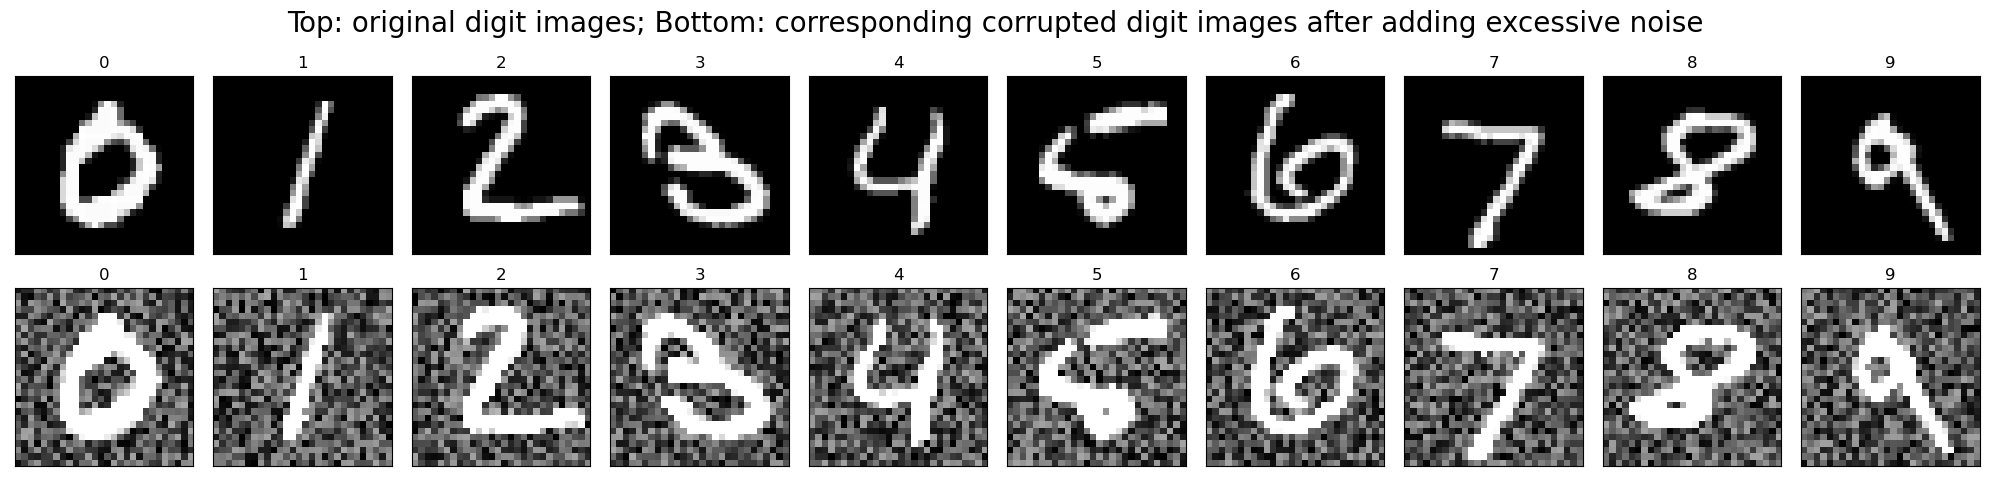

In [8]:
# Show the original images and corresponding images after adding excessive noise

fig, ax = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,5))

ax = ax.flatten()

orig_map=plt.cm.get_cmap('Greys')
reversed_map = orig_map.reversed()

for i in range(10):
    image_normal_temp = normal.loc[normal['label']==i].iloc[0].to_numpy()
    image_normal = image_normal_temp[1:].reshape(28,28)
    ax[i].imshow(image_normal, cmap='gray')
    ax[i].set_title('{}'.format(i))
    
    image_anom_temp = anomalous.loc[anomalous['label']==i].iloc[0].to_numpy()
    image_anom = image_anom_temp[1:].reshape(28,28)
    #ax[i].imshow(image_anom, cmap=reversed_map)
    ax[i+10].imshow(image_anom, cmap='gray')
    ax[i+10].set_title('{}'.format(i))
    
ax[0].set_xticks([])
ax[0].set_yticks([])

fig.suptitle('Top: original digit images; Bottom: corresponding corrupted digit images after adding excessive noise', fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('uncorrupted_corrupted_images.pdf')

### create the CSV files to be used in the testing time ###

In [9]:
# for quesstion 2: compare the original uncorrupted images with corrupted images (byy adding excessive noise)
normal.to_csv('normal.csv', index=False)

anom_test = pd.concat([anomalous, clean])  # join together the anomalous samples and non-anomalous samples
anom_test.to_csv('test_anomaly.csv', index=False)          # save the samples in a CSV file

# edit the label to a binary annotation: anomalous or non-anomalous, which is 1 and 0, respectively.
anomalous.loc[:,'label'] = 1    # anomalous samples
clean.loc[:,'label'] = 0   # non-anomalous samples
anom_test_ = pd.concat([anomalous, clean])  # join together the anomalous samples and non-anomalous samples

anom_test_.to_csv('test_anomaly_.csv', index=False)          # save the samples in a CSV file
print(anom_test.shape)

/tmp/ipykernel_36935/2746057296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalous.loc[:,'label'] = 1    # anomalous samples
/tmp/ipykernel_36935/2746057296.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:,'label'] = 0   # non-anomalous samples


(10000, 785)


### Create the data loader for the nornal and test datasets ###

In [10]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'}) # remove the column with named 'label'
        data = torch.from_numpy(np.array(row)/255).float() # normalizes (divides by 255) to a 0–1 range that better serves training efficiency
        return data

class normalTestLoader(Loader):
    def __init__(self):
        super(normalTestLoader, self).__init__()
        self.dataset = pd.read_csv('normal.csv', index_col=False) # index_col=False: remove the label column (in the first column) of each row

class testLoader(Loader):
    def __init__(self):
        super(testLoader, self).__init__()
        self.dataset = pd.read_csv('test_anomaly.csv', index_col=False) # index_col=False: remove the label column (in the first column) of each row

normalTestset = normalTestLoader()
testset = testLoader()

# normal data loader
# this test data loader contains 10% of normal data
normalLoader = torch.utils.data.DataLoader(
                normalTestset,
                batch_size = batch_size,
                shuffle=False,
                num_workers=1,
                pin_memory=True)

# test data loader (for testing time)
# this test data loader contains 90% of normal data and 10% of anomalous data
testLoader = torch.utils.data.DataLoader(
                testset,
                batch_size = batch_size,
                shuffle=False,
                num_workers=1,
                pin_memory=True)

# Mean Squared Error (MSE) #

In [11]:
def mse(Y, X):
    '''
    compute the mean squared error (MSE)
    
    Parameters:
        Y: output images of the autoencoder
        X: input images of the autoencoder
    '''
    MSE = torch.square(torch.subtract(Y, X)).mean()
    return MSE

class MSE(torch.nn.Module):
    '''
    class for Mean Squared Error (MSE)
    
    Parameters:
        None
    '''
    def __init__(self):
        super(MSE, self).__init__()
    
    def forward(self, Y, X):
        return mse(Y, X)

# Structural Similarity Index Measure (SSIM) #
http://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf

In [12]:
# implementation of the SSIM according to the original SSIM paper (http://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf)
# the value of constants are selected based on original SSIM paper (http://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf)

def _fspecial_gauss_1d(size, sigma):
    """
    Create the 1-D gauss kernel
    
    Parameters:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)


def gaussian_filter(input, win):
    """
    Blur the input with 1-D kernel
    
    Parameters:
        input (torch.Tensor): a batch of tensors to be blurred
        window (torch.Tensor): 1-D gauss kernel
    Returns:
        torch.Tensor: blurred tensors
    """
    assert all([ws == 1 for ws in win.shape[1:-1]]), win.shape
    if len(input.shape) == 4:
        conv = F.conv2d
    elif len(input.shape) == 5:
        conv = F.conv3d

    C = input.shape[1]
    out = input
    for i, s in enumerate(input.shape[2:]):
        if s >= win.shape[-1]:
            out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)

    return out

def _ssim(X, Y, data_range, win, K=(0.01, 0.03)):
    """
    Calculate ssim index for X and Y
    
    Parameters:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        win (torch.Tensor): 1-D gauss kernel
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
    Returns:
        torch.Tensor: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)  # set alpha=beta=gamma=1
    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
    cs = torch.flatten(cs_map, 2).mean(-1)
    
    return ssim_per_channel, cs

def ssim(
    X,
    Y,
    data_range=1.0,
    win_size=11,
    win_sigma=1.5,
    win=None,
    K=(0.01, 0.03),
):
    """
    interface of SSIM
    
    Parameters:
        X (torch.Tensor): a batch of images, (N,C,H,W)
        Y (torch.Tensor): a batch of images, (N,C,H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
        nonnegative_ssim (bool, optional): force the ssim response to be nonnegative with relu
    Returns:
        torch.Tensor: ssim results
    """

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    ssim_per_channel, cs = _ssim(X, Y, data_range=data_range, win=win, K=K)
    
    return ssim_per_channel.mean()

class SSIM(torch.nn.Module):
    def __init__(
        self,
        data_range=1.0,
        win_size=11,
        win_sigma=1.5,
        channel=1,
        spatial_dims=2,
        K=(0.01, 0.03),
    ):
        """
        class for SSIM
        
        Parameters:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
            nonnegative_ssim (bool, optional): force the ssim response to be nonnegative with relu.
        """

        super(SSIM, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.data_range = data_range
        self.K = K

    def forward(self, X, Y):
        return ssim(
            X,
            Y,
            data_range=self.data_range,
            win=self.win,
            K=self.K,
        )

# Simple autoencoder model #

In [13]:
class vanillaAutoEncoder(nn.Module):
    def __init__(self):
        super(vanillaAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

vanillaAEmodel = vanillaAutoEncoder().to(device=device)
print(vanillaAEmodel)

vanillaAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


# Complex autoencoder model #

In [14]:
class complexAutoEncoder(nn.Module):
    def __init__(self):
        super(complexAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256), #applying batch norm
            nn.ReLU(),
            nn.Linear(256, 128),
#            nn.Dropout(0.2), #20 % probability
            nn.BatchNorm1d(128), #applying batch norm
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
#            nn.Dropout(0.2),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )   
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

complexAEmodel = complexAutoEncoder().to(device=device)
print(complexAEmodel)

complexAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=12, bias=True)
    (11): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

# Convolutional autoencoder model #

In [15]:
class convAutoencoder(nn.Module):
    def __init__(self):
        super(convAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

convAEmodel = convAutoencoder().to(device=device)
print(convAEmodel)

convAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


## function for training of the fully-connected simple and complex autoencoders ##

In [16]:
def trainFC(num_epochs, model, lossFunc="MSE", optimization="SGD", lr=0.001, momentum=0.9):
    """
    define a function to train the model
    
    Parameters:
    ----------
    num_epochs: number of epochs, i.e. total number of passes through the whole samples in the trainng and validation datasets
    model: the created neural network
    lossFunc: loss function
    optimization: optimization algorithm
    lr: learning rate
    monemtum: momentum for SGD optimizer
    
    Return:
    -------
    train_losses: the list of train loss in each epoch
    valid_losses: the list of validation loss in each epoch
    """
    
    train_losses = []
    valid_losses = []
    
    if lossFunc=="MSE":
        #lossfunc = nn.MSELoss()
        lossfunc = MSE()
    elif lossFunc=="SSIM":
        #lossfunc = SSIM(window_size=11, sigma=1.5, n_channels=1, reduction='mean').cuda()   # .cuda() if you need GPU support
        lossfunc = SSIM()
    
    if optimization=="SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimization=="Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        ###############
        # train model #
        ###############
        model.train()
        epoch_train_loss = 0.0
        for i, (images, labels) in enumerate(trainLoader):
            images = Variable(images.view(-1, 28*28)).to(device=device)   # batch x, shape (batch, 28*28)
            labels = Variable(labels).to(device=device)               # batch label
            
            decoded = model(images)
            
            if lossFunc=="SSIM":
                decoded = decoded.view(-1, 1, 28, 28)
                images_ = images.view(-1, 1, 28, 28)
                loss = 1-lossfunc(decoded, images_)
            else:
                loss = lossfunc(decoded, images)
            
            epoch_train_loss += loss.item()*images.size(0)
            
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
        
        train_losses.append(epoch_train_loss/len(trainLoader))
        
        ##################
        # validate model #
        ##################
        model.eval()
        epoch_valid_loss = 0.0
        with torch.no_grad():
            for i, (images, labels) in enumerate(validLoader):
                images = Variable(images.view(-1, 28*28)).to(device=device)   # batch x, shape (batch, 28*28)
                labels = Variable(labels).to(device=device)               # batch label
                
                decoded = model(images)
                
                if lossFunc=="SSIM":
                    decoded = decoded.view(-1, 1, 28, 28)
                    images_ = images.view(-1, 1, 28, 28)
                    loss = 1-lossfunc(decoded, images_)
                else:
                    loss = lossfunc(decoded, images)
                
                epoch_valid_loss += loss.item()*images.size(0)
            
            valid_losses.append(epoch_valid_loss/len(validLoader))
        
        print('Epoch: {}/{}'.format(epoch+1, num_epochs),
              '\t train loss: {:.4f}'.format(epoch_train_loss/len(trainLoader)),
              '\t validation loss: {:.4f}'.format(epoch_valid_loss/len(validLoader)))
        
        ######## 
        # plot #
        ########
        if epoch==0 or epoch%10==0:
            # Lets get batch of test images
            dataiter = iter(validLoader)
            images, labels = dataiter.next()
            images_input = Variable(images.view(-1, 28*28)).to(device=device)   # batch x, shape (batch, 28*28)
            
            decoded = model(images_input)
            
            images = images.cpu().numpy()                    # prep images for display
            decoded = decoded.cpu().view(batch_size, 1, 28, 28)# resizing output
            decoded = decoded.detach().numpy()           # use detach when it's an output that requires_grad
            
            # plot the input images and then reconstructed images
            fig, axes = plt.subplots(nrows=2, ncols=16, sharex=True, sharey=True, figsize=(12,2))
            # input images on top row, reconstructions on bottom
            for images, row in zip([images, decoded], axes):
                for img, ax in zip(images, row):
                    ax.imshow(np.squeeze(img), cmap='gray')
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
            plt.show();
    
    ##############
    # Checkpoint #
    ##############
    PATH = "checkpoint_{}_{}loss.pt".format(model.__class__.__name__, lossFunc)

    torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)
        
    return train_losses, valid_losses

## function for training of the convolutional autoencoder model ##

In [17]:
def trainConv(num_epochs, model, lossFunc="MSE", optimization="SGD", lr=0.001, momentum=0.9):
    """
    define a function to train the model
    
    Parameters:
    ----------
    num_epochs: number of epochs, i.e. total number of passes through the whole samples in the trainng and validation datasets
    model: the created neural network
    lossFunc: loss function
    optimization: optimization algorithm
    lr: learning rate
    monemtum: momentum for SGD optimizer
    
    Return:
    -------
    train_losses: the list of train loss in each epoch
    valid_losses: the list of validation loss in each epoch
    """
    
    train_losses = []
    valid_losses = []
    
    if lossFunc=="MSE":
        #lossfunc = nn.MSELoss()
        lossfunc = MSE()
    elif lossFunc=="SSIM":
        # lossfunc = SSIM(window_size=11, sigma=1.5, n_channels=1, reduction='mean').cuda()   # .cuda() if you need GPU support
        lossfunc = SSIM()
    
    if optimization=="SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimization=="Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    for epoch in range(1, num_epochs+1):
        ###################
        # train the model #
        ###################
        train_loss = 0.0  # monitor training loss
        
        for i, data in enumerate(trainLoader):
            images, _ = data                        # we are just intrested in just images
            images = images.to(device=device)
            # no need to flatten images
            optimizer.zero_grad()                   # clear the gradients
            outputs = model(images)                 # forward pass: compute predicted outputs 
            loss = lossfunc(outputs, images)       # calculate the loss
            loss.backward()                         # backward pass
            optimizer.step()                        # perform optimization step
            
            train_loss += loss.item()*images.size(0)# update running training loss
            
        # print avg training statistics 
        train_loss = train_loss/len(trainLoader)
        train_losses.append(train_loss)
        
        ######################
        # validate the model #
        ######################
        valid_loss = 0.0 # monitor valid loss
        
        for i, data in enumerate(validLoader):
            images, _ = data                        # we are just intrested in just image
            images = images.to(device=device)
            optimizer.zero_grad()                   # clear the gradients
            decoded = model(images)                 # forward pass: compute predicted outputs
            loss = lossfunc(decoded, images)       # calculate the loss
            valid_loss += loss.item()*images.size(0)# update running training loss
        
        # print avg valid statistics 
        valid_loss = valid_loss/len(trainLoader)
        valid_losses.append(valid_loss)
        
        print('Epoch: {}/{}'.format(epoch, num_epochs),
              '\tTraining Loss: {:.4f}'.format(train_loss),
              '\tValidation Loss: {:.4f}'.format(valid_loss))
        
        ######## 
        # plot #
        ########
        if epoch==1 or epoch%10==0:
            # Lets get batch of test images
            dataiter = iter(validLoader)
            images, labels = dataiter.next()
            images = Variable(images).to(device=device)   # batch x, shape (batch, 28*28)
            
            decoded = model(images)                     # get sample outputs
            images = images.cpu().numpy()                    # prep images for display
            decoded = decoded.cpu()                     # resizing output
            decoded = decoded.detach().numpy()           # use detach when it's an output that requires_grad
            
            # plot the input images and then reconstructed images
            fig, axes = plt.subplots(nrows=2, ncols=16, sharex=True, sharey=True, figsize=(12,2))
            # input images on top row, reconstructions on bottom
            for images, row in zip([images, decoded], axes):
                for img, ax in zip(images, row):
                    ax.imshow(np.squeeze(img), cmap='gray')
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
            plt.show();
    
    ##############
    # Checkpoint #
    ##############
    PATH = "checkpoint_{}_{}loss.pt".format(model.__class__.__name__, lossFunc)

    torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)
        
    return train_losses, valid_losses

## function of plotting the trainning and validation lossed to number of epochs ##

In [18]:
# plot the training and validation losses versus epochs
def plotLossesEpochs(num_epochs, trainLosses, validLosses, model="vanilla", lossFunc="MSE"):
    '''
    function for plotting the training and validation losses to number of epochs
    
    Parameters:
        num_epochs: number of epochs
        trainLosses: list of train loss of every epoch 
        validLosses: list of validation loss of every epoch
        model: autoencoder mode
        lossFunc: loss function
    
    Return:
        None
    '''

    fg = figure(figsize=(10, 8), dpi=80)
    ax = fg.gca()

    epochs_range = np.arange(1,num_epochs+1)

    # plotting
    plt.title("Train loss and valid loss vs epochs for {} model ({} loss)".format(model, lossFunc), fontsize=19)
    plt.xlabel("epoch", fontsize=30)
    plt.ylabel("loss", fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    plt.plot(epochs_range, trainLosses, color ="red")
    plt.plot(epochs_range, validLosses, color ="blue")
    plt.legend(['train loss', 'valid loss'], loc='best', fontsize=30)
    #plt.show()
    plt.savefig('train_valid_losses_versus_epochs_{}_{}loss.pdf'.format(model, lossFunc))

## function for testing of the fully-connected simple and complex autoencoders ##

In [19]:
def testFC(model, lossFunc="MSE"):
    '''
    function for testing the fully-connected simple and complex autonencoder models and display the output of the model
    
    Parameters:
        model: autoencoder model
        lossFunc: loss function
    
    Return:
        None
    '''
    n_imgs = 18
    model.eval()
    with torch.no_grad():
        for i, (data) in enumerate(testLoader):
            data = data.to(device=device)
            decoded = model(data)
            if i==0:
                input_images = data[:n_imgs].cpu().detach().numpy()
                output_images = decoded[:n_imgs].cpu().detach().numpy()
                #print(input_images.shape)
                #print(output_images.shape) 
                fig, ax = plt.subplots(nrows=2, ncols=n_imgs, sharex=True, sharey=True, figsize=(20,3))
                plt.suptitle("Top: corrupted images (with excessive noise); bottom: output from autoencoder ({} loss)".format(lossFunc))
                ax = ax.flatten()
                for k in range(n_imgs):
                    image_input = input_images[k].reshape(28,28)
                    ax[k].imshow(image_input, cmap='gray')  # cmap='Greys'
                    image_output = output_images[k].reshape(28,28)
                    ax[k+n_imgs].imshow(image_output, cmap='gray')
                plt.savefig('{}_corrupted_output_images_{}loss.pdf'.format(model.__class__.__name__, lossFunc), format='pdf', bbox_inches='tight')
        
        for i, (data) in enumerate(normalLoader):
            data = data.to(device=device)
            decoded = model(data)
            if i==0:
                input_images = data[:n_imgs].cpu().detach().numpy()
                output_images = decoded[:n_imgs].cpu().detach().numpy()
                fig, ax = plt.subplots(nrows=2, ncols=n_imgs, sharex=True, sharey=True, figsize=(20,3))
                plt.suptitle("Top: original uncorrupted images; bottom: output from autoencoder ({} loss)".format(lossFunc))
                ax = ax.flatten()
                for k in range(n_imgs):
                    image_input = input_images[k].reshape(28,28)
                    ax[k].imshow(image_input, cmap='gray')
                    image_output = output_images[k].reshape(28,28)
                    ax[k+n_imgs].imshow(image_output, cmap='gray')
                plt.savefig('{}_uncorrupted_output_images_{}loss.pdf'.format(model.__class__.__name__, lossFunc), format='pdf', bbox_inches='tight')

## function for testing of the convolutional autoencoder model ##

In [20]:
def testConv(model, lossFunc="MSE"):
    '''
    function for testing the convolutional autonencoder model and display the output of the model
    
    Parameters:
        model: autoencoder model
        lossFunc: loss function
    
    Return:
        None
    '''
    n_imgs = 18
    model.eval()
    with torch.no_grad():
        for i, (data) in enumerate(testLoader):
            data_ = data.view(-1, 1, 28, 28).to(device=device)
            decoded = model(data_)
            if i==0:
                input_images = data[:n_imgs].cpu().detach().numpy()
                output_images = decoded[:n_imgs].cpu().detach().numpy()
                fig, ax = plt.subplots(nrows=2, ncols=n_imgs, sharex=True, sharey=True, figsize=(20,3))
                plt.suptitle("Top: corrupted images (with excessive noise); bottom: output from autoencoder ({} loss)".format(lossFunc))
                ax = ax.flatten()
                for k in range(n_imgs):
                    image_input = input_images[k].reshape(28,28)
                    ax[k].imshow(image_input, cmap='gray')  # cmap='Greys'
                    image_output = output_images[k].reshape(28,28)
                    ax[k+n_imgs].imshow(image_output, cmap='gray')
                plt.savefig('{}_corrupted_output_images_{}loss.pdf'.format(model.__class__.__name__, lossFunc), format='pdf', bbox_inches='tight')
        
        for i, (data) in enumerate(normalLoader):
            data_ = data.view(-1, 1, 28, 28).to(device=device)
            decoded = model(data_)
            if i==0:
                input_images = data[:n_imgs].cpu().detach().numpy()
                output_images = decoded[:n_imgs].cpu().detach().numpy()
                fig, ax = plt.subplots(nrows=2, ncols=n_imgs, sharex=True, sharey=True, figsize=(20,3))
                plt.suptitle("Top: original uncorrupted images; bottom: output from autoencoder ({} loss)".format(lossFunc))
                ax = ax.flatten()
                for k in range(n_imgs):
                    image_input = input_images[k].reshape(28,28)
                    ax[k].imshow(image_input, cmap='gray')
                    image_output = output_images[k].reshape(28,28)
                    ax[k+n_imgs].imshow(image_output, cmap='gray')
                plt.savefig('{}_uncorrupted_output_images_{}loss.pdf'.format(model.__class__.__name__, lossFunc), format='pdf', bbox_inches='tight')

# Train the models #

Epoch: 1/100 	 train loss: 16.8560 	 validation loss: 6.8315


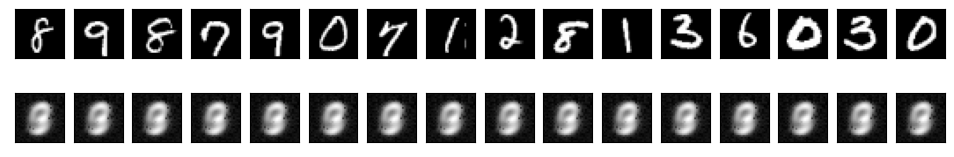

Epoch: 2/100 	 train loss: 6.7730 	 validation loss: 6.7159
Epoch: 3/100 	 train loss: 6.7259 	 validation loss: 6.6755
Epoch: 4/100 	 train loss: 6.6700 	 validation loss: 6.5938
Epoch: 5/100 	 train loss: 6.5391 	 validation loss: 6.4355
Epoch: 6/100 	 train loss: 6.4337 	 validation loss: 6.3742
Epoch: 7/100 	 train loss: 6.3839 	 validation loss: 6.3320
Epoch: 8/100 	 train loss: 6.3445 	 validation loss: 6.2954
Epoch: 9/100 	 train loss: 6.3054 	 validation loss: 6.2532
Epoch: 10/100 	 train loss: 6.2610 	 validation loss: 6.2072
Epoch: 11/100 	 train loss: 6.2087 	 validation loss: 6.1511


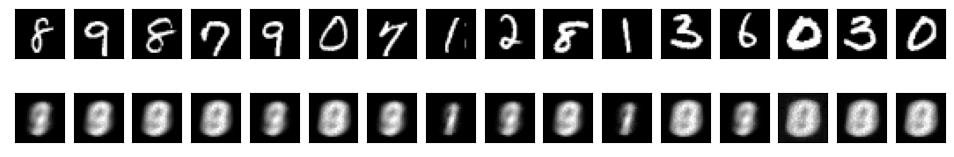

Epoch: 12/100 	 train loss: 6.1629 	 validation loss: 6.1171
Epoch: 13/100 	 train loss: 6.1323 	 validation loss: 6.0884
Epoch: 14/100 	 train loss: 6.1106 	 validation loss: 6.0712
Epoch: 15/100 	 train loss: 6.0932 	 validation loss: 6.0580
Epoch: 16/100 	 train loss: 6.0777 	 validation loss: 6.0381
Epoch: 17/100 	 train loss: 6.0634 	 validation loss: 6.0222
Epoch: 18/100 	 train loss: 6.0473 	 validation loss: 6.0103
Epoch: 19/100 	 train loss: 6.0314 	 validation loss: 5.9937
Epoch: 20/100 	 train loss: 6.0106 	 validation loss: 5.9712
Epoch: 21/100 	 train loss: 5.9869 	 validation loss: 5.9433


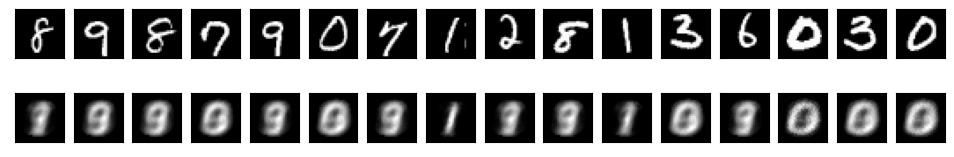

Epoch: 22/100 	 train loss: 5.9565 	 validation loss: 5.9066
Epoch: 23/100 	 train loss: 5.9148 	 validation loss: 5.8575
Epoch: 24/100 	 train loss: 5.8504 	 validation loss: 5.7832
Epoch: 25/100 	 train loss: 5.7741 	 validation loss: 5.7196
Epoch: 26/100 	 train loss: 5.7179 	 validation loss: 5.6674
Epoch: 27/100 	 train loss: 5.6713 	 validation loss: 5.6209
Epoch: 28/100 	 train loss: 5.6241 	 validation loss: 5.5738
Epoch: 29/100 	 train loss: 5.5764 	 validation loss: 5.5299
Epoch: 30/100 	 train loss: 5.5292 	 validation loss: 5.4821
Epoch: 31/100 	 train loss: 5.4862 	 validation loss: 5.4515


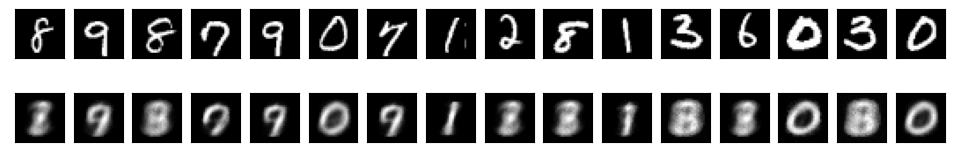

Epoch: 32/100 	 train loss: 5.4526 	 validation loss: 5.4148
Epoch: 33/100 	 train loss: 5.4238 	 validation loss: 5.3904
Epoch: 34/100 	 train loss: 5.4008 	 validation loss: 5.3716
Epoch: 35/100 	 train loss: 5.3802 	 validation loss: 5.3534
Epoch: 36/100 	 train loss: 5.3616 	 validation loss: 5.3299
Epoch: 37/100 	 train loss: 5.3432 	 validation loss: 5.3142
Epoch: 38/100 	 train loss: 5.3261 	 validation loss: 5.2998
Epoch: 39/100 	 train loss: 5.3082 	 validation loss: 5.2813
Epoch: 40/100 	 train loss: 5.2908 	 validation loss: 5.2675
Epoch: 41/100 	 train loss: 5.2747 	 validation loss: 5.2471


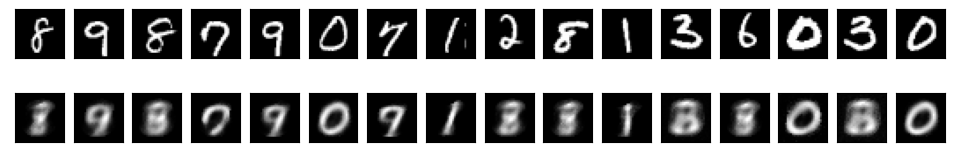

Epoch: 42/100 	 train loss: 5.2593 	 validation loss: 5.2353
Epoch: 43/100 	 train loss: 5.2450 	 validation loss: 5.2243
Epoch: 44/100 	 train loss: 5.2304 	 validation loss: 5.2104
Epoch: 45/100 	 train loss: 5.2170 	 validation loss: 5.1955
Epoch: 46/100 	 train loss: 5.2034 	 validation loss: 5.1793
Epoch: 47/100 	 train loss: 5.1904 	 validation loss: 5.1723
Epoch: 48/100 	 train loss: 5.1775 	 validation loss: 5.1556
Epoch: 49/100 	 train loss: 5.1646 	 validation loss: 5.1457
Epoch: 50/100 	 train loss: 5.1517 	 validation loss: 5.1308
Epoch: 51/100 	 train loss: 5.1378 	 validation loss: 5.1147


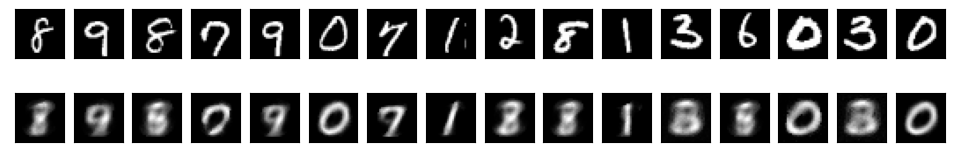

Epoch: 52/100 	 train loss: 5.1241 	 validation loss: 5.1023
Epoch: 53/100 	 train loss: 5.1085 	 validation loss: 5.0891
Epoch: 54/100 	 train loss: 5.0921 	 validation loss: 5.0709
Epoch: 55/100 	 train loss: 5.0721 	 validation loss: 5.0470
Epoch: 56/100 	 train loss: 5.0447 	 validation loss: 5.0119
Epoch: 57/100 	 train loss: 5.0051 	 validation loss: 4.9661
Epoch: 58/100 	 train loss: 4.9466 	 validation loss: 4.9020
Epoch: 59/100 	 train loss: 4.8850 	 validation loss: 4.8482
Epoch: 60/100 	 train loss: 4.8360 	 validation loss: 4.8053
Epoch: 61/100 	 train loss: 4.7946 	 validation loss: 4.7677


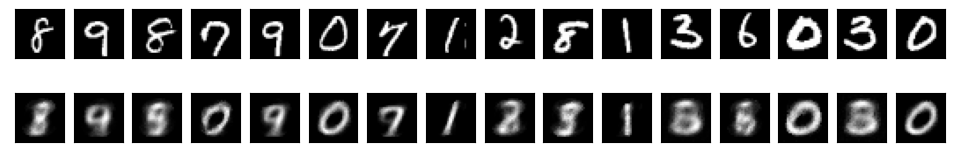

Epoch: 62/100 	 train loss: 4.7609 	 validation loss: 4.7399
Epoch: 63/100 	 train loss: 4.7303 	 validation loss: 4.7090
Epoch: 64/100 	 train loss: 4.7037 	 validation loss: 4.6880
Epoch: 65/100 	 train loss: 4.6789 	 validation loss: 4.6618
Epoch: 66/100 	 train loss: 4.6559 	 validation loss: 4.6381
Epoch: 67/100 	 train loss: 4.6347 	 validation loss: 4.6158
Epoch: 68/100 	 train loss: 4.6122 	 validation loss: 4.5970
Epoch: 69/100 	 train loss: 4.5920 	 validation loss: 4.5757
Epoch: 70/100 	 train loss: 4.5704 	 validation loss: 4.5565
Epoch: 71/100 	 train loss: 4.5506 	 validation loss: 4.5376


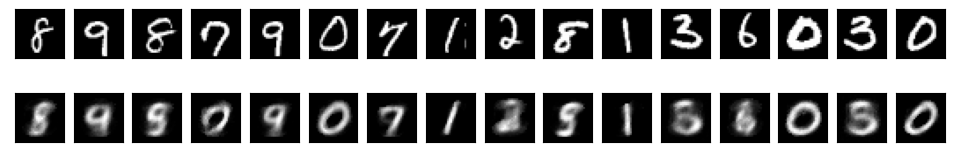

Epoch: 72/100 	 train loss: 4.5304 	 validation loss: 4.5187
Epoch: 73/100 	 train loss: 4.5120 	 validation loss: 4.5026
Epoch: 74/100 	 train loss: 4.4941 	 validation loss: 4.4881
Epoch: 75/100 	 train loss: 4.4764 	 validation loss: 4.4753
Epoch: 76/100 	 train loss: 4.4596 	 validation loss: 4.4599
Epoch: 77/100 	 train loss: 4.4441 	 validation loss: 4.4435
Epoch: 78/100 	 train loss: 4.4291 	 validation loss: 4.4284
Epoch: 79/100 	 train loss: 4.4140 	 validation loss: 4.4111
Epoch: 80/100 	 train loss: 4.4001 	 validation loss: 4.3997
Epoch: 81/100 	 train loss: 4.3868 	 validation loss: 4.3901


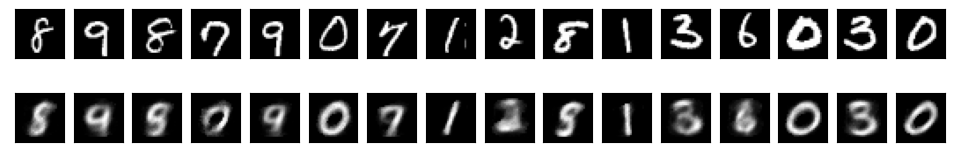

Epoch: 82/100 	 train loss: 4.3725 	 validation loss: 4.3770
Epoch: 83/100 	 train loss: 4.3599 	 validation loss: 4.3631
Epoch: 84/100 	 train loss: 4.3470 	 validation loss: 4.3497
Epoch: 85/100 	 train loss: 4.3335 	 validation loss: 4.3395
Epoch: 86/100 	 train loss: 4.3216 	 validation loss: 4.3292
Epoch: 87/100 	 train loss: 4.3084 	 validation loss: 4.3175
Epoch: 88/100 	 train loss: 4.2952 	 validation loss: 4.3027
Epoch: 89/100 	 train loss: 4.2822 	 validation loss: 4.2889
Epoch: 90/100 	 train loss: 4.2697 	 validation loss: 4.2770
Epoch: 91/100 	 train loss: 4.2578 	 validation loss: 4.2663


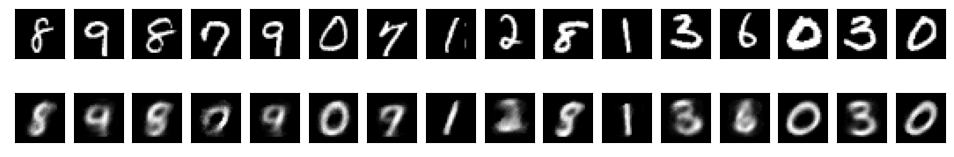

Epoch: 92/100 	 train loss: 4.2451 	 validation loss: 4.2563
Epoch: 93/100 	 train loss: 4.2324 	 validation loss: 4.2373
Epoch: 94/100 	 train loss: 4.2195 	 validation loss: 4.2244
Epoch: 95/100 	 train loss: 4.2070 	 validation loss: 4.2158
Epoch: 96/100 	 train loss: 4.1948 	 validation loss: 4.2033
Epoch: 97/100 	 train loss: 4.1835 	 validation loss: 4.1913
Epoch: 98/100 	 train loss: 4.1712 	 validation loss: 4.1793
Epoch: 99/100 	 train loss: 4.1603 	 validation loss: 4.1665
Epoch: 100/100 	 train loss: 4.1480 	 validation loss: 4.1558


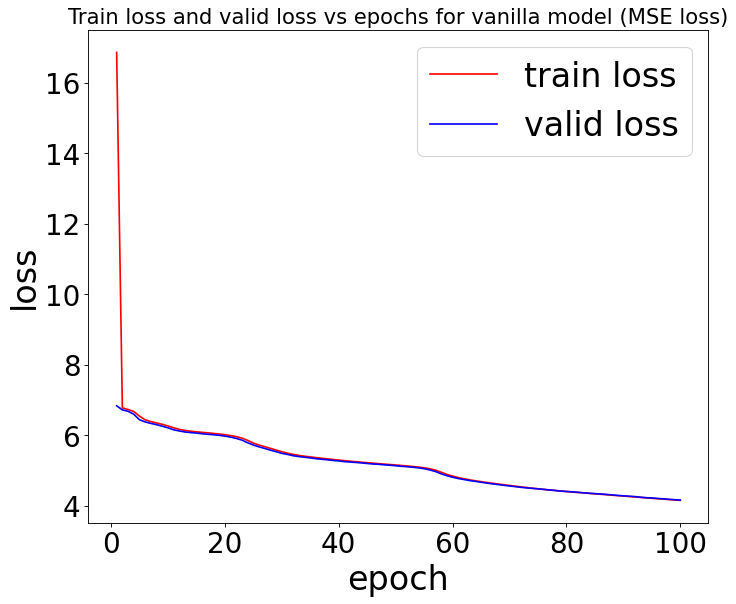

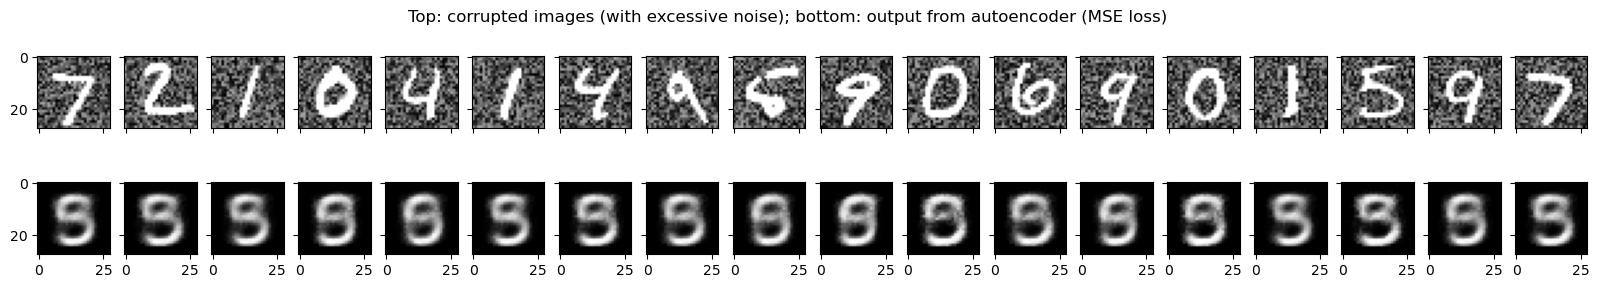

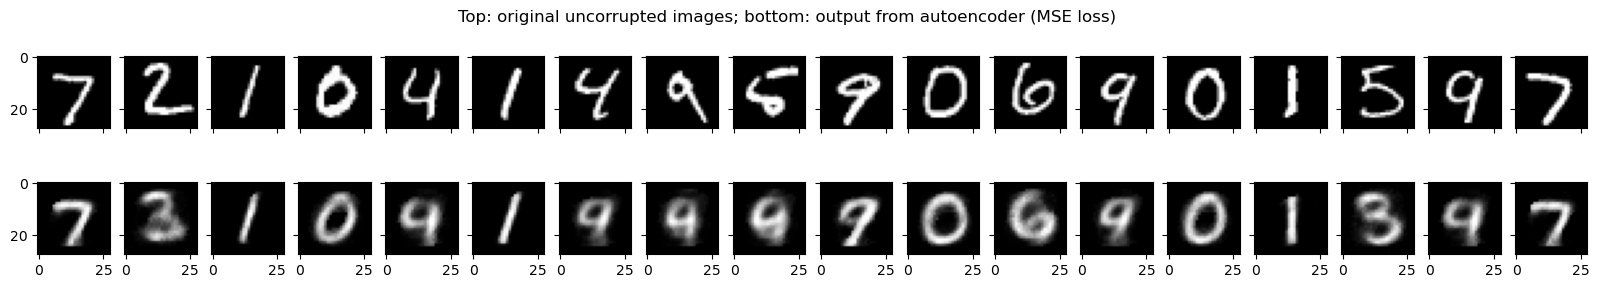

In [21]:
#trainLossesVanillaAEmodel, validLossesVanillaAEmodel = trainFC(num_epochs, vanillaAEmodel, lossFunc="MSE", optimization="SGD", lr=learning_rate, momentum=momentum)

trainLossesVanillaAEmodel, validLossesVanillaAEmodel = trainFC(num_epochs, vanillaAEmodel, lossFunc="MSE", optimization="SGD", lr=0.05, momentum=momentum)
plotLossesEpochs(num_epochs, trainLossesVanillaAEmodel, validLossesVanillaAEmodel, model="vanilla", lossFunc="MSE")
testFC(vanillaAEmodel, lossFunc="MSE")

Epoch: 1/100 	 train loss: 91.7180 	 validation loss: 81.7428


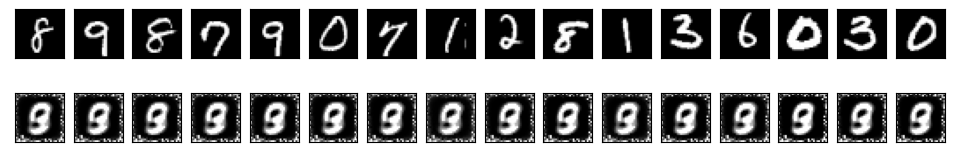

Epoch: 2/100 	 train loss: 80.2857 	 validation loss: 79.3657
Epoch: 3/100 	 train loss: 78.2883 	 validation loss: 76.9257
Epoch: 4/100 	 train loss: 75.6437 	 validation loss: 74.8834
Epoch: 5/100 	 train loss: 74.1565 	 validation loss: 73.7274
Epoch: 6/100 	 train loss: 73.3306 	 validation loss: 73.0549
Epoch: 7/100 	 train loss: 72.8739 	 validation loss: 72.8100
Epoch: 8/100 	 train loss: 72.5481 	 validation loss: 72.4335
Epoch: 9/100 	 train loss: 72.2855 	 validation loss: 72.1724
Epoch: 10/100 	 train loss: 71.9698 	 validation loss: 71.8159
Epoch: 11/100 	 train loss: 71.5135 	 validation loss: 71.4067


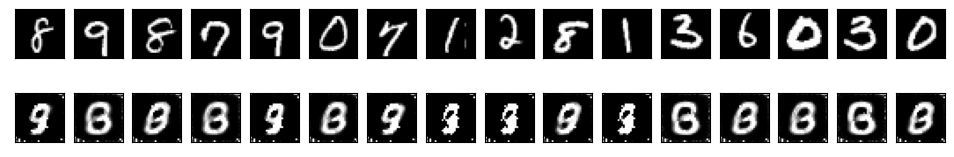

Epoch: 12/100 	 train loss: 71.2792 	 validation loss: 71.1877
Epoch: 13/100 	 train loss: 71.0892 	 validation loss: 70.9981
Epoch: 14/100 	 train loss: 70.7583 	 validation loss: 70.3791
Epoch: 15/100 	 train loss: 69.7792 	 validation loss: 69.5064
Epoch: 16/100 	 train loss: 69.2322 	 validation loss: 68.9963
Epoch: 17/100 	 train loss: 68.5981 	 validation loss: 67.9385
Epoch: 18/100 	 train loss: 67.0174 	 validation loss: 66.0616
Epoch: 19/100 	 train loss: 65.3855 	 validation loss: 64.8575
Epoch: 20/100 	 train loss: 64.3243 	 validation loss: 63.9170
Epoch: 21/100 	 train loss: 63.3189 	 validation loss: 62.6165


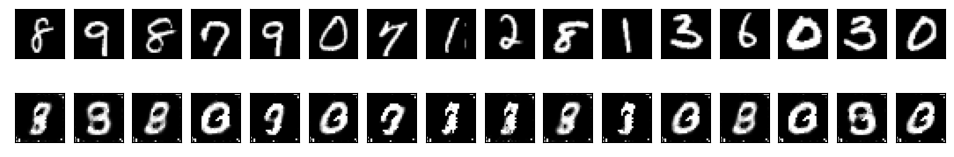

Epoch: 22/100 	 train loss: 62.0200 	 validation loss: 61.7231
Epoch: 23/100 	 train loss: 61.3319 	 validation loss: 60.9619
Epoch: 24/100 	 train loss: 60.3845 	 validation loss: 59.6208
Epoch: 25/100 	 train loss: 59.0016 	 validation loss: 58.3722
Epoch: 26/100 	 train loss: 57.2328 	 validation loss: 56.7530
Epoch: 27/100 	 train loss: 56.2382 	 validation loss: 55.9557
Epoch: 28/100 	 train loss: 55.3017 	 validation loss: 54.7594
Epoch: 29/100 	 train loss: 54.0348 	 validation loss: 53.4599
Epoch: 30/100 	 train loss: 52.7877 	 validation loss: 52.2878
Epoch: 31/100 	 train loss: 51.8318 	 validation loss: 51.6995


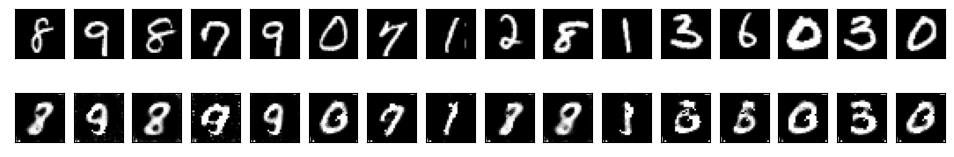

Epoch: 32/100 	 train loss: 51.0069 	 validation loss: 50.7523
Epoch: 33/100 	 train loss: 50.4052 	 validation loss: 50.2715
Epoch: 34/100 	 train loss: 49.9326 	 validation loss: 49.4751
Epoch: 35/100 	 train loss: 49.0506 	 validation loss: 48.9230
Epoch: 36/100 	 train loss: 48.6123 	 validation loss: 48.4401
Epoch: 37/100 	 train loss: 48.1793 	 validation loss: 48.0929
Epoch: 38/100 	 train loss: 47.9105 	 validation loss: 47.8863
Epoch: 39/100 	 train loss: 47.6335 	 validation loss: 47.8205
Epoch: 40/100 	 train loss: 47.2118 	 validation loss: 47.1783
Epoch: 41/100 	 train loss: 46.9185 	 validation loss: 46.9084


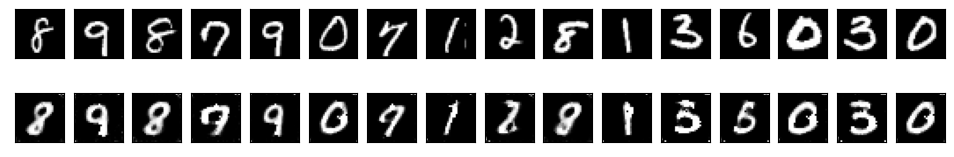

Epoch: 42/100 	 train loss: 46.5882 	 validation loss: 46.5950
Epoch: 43/100 	 train loss: 46.4027 	 validation loss: 46.4356
Epoch: 44/100 	 train loss: 46.1657 	 validation loss: 46.1989
Epoch: 45/100 	 train loss: 45.8000 	 validation loss: 45.7738
Epoch: 46/100 	 train loss: 45.5790 	 validation loss: 45.4845
Epoch: 47/100 	 train loss: 45.3754 	 validation loss: 45.4729
Epoch: 48/100 	 train loss: 45.0883 	 validation loss: 45.0626
Epoch: 49/100 	 train loss: 44.8037 	 validation loss: 44.8170
Epoch: 50/100 	 train loss: 44.2892 	 validation loss: 44.1986
Epoch: 51/100 	 train loss: 43.9350 	 validation loss: 43.9574


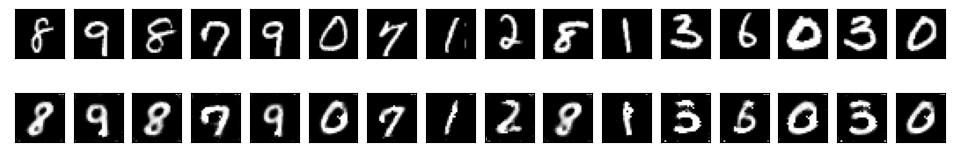

Epoch: 52/100 	 train loss: 43.6843 	 validation loss: 43.9181
Epoch: 53/100 	 train loss: 43.4111 	 validation loss: 43.3483
Epoch: 54/100 	 train loss: 43.2235 	 validation loss: 43.2868
Epoch: 55/100 	 train loss: 43.0319 	 validation loss: 43.0230
Epoch: 56/100 	 train loss: 42.8365 	 validation loss: 42.8851
Epoch: 57/100 	 train loss: 42.6534 	 validation loss: 42.7464
Epoch: 58/100 	 train loss: 42.4393 	 validation loss: 42.5049
Epoch: 59/100 	 train loss: 42.2445 	 validation loss: 42.4274
Epoch: 60/100 	 train loss: 42.1356 	 validation loss: 42.4630
Epoch: 61/100 	 train loss: 41.9787 	 validation loss: 42.2676


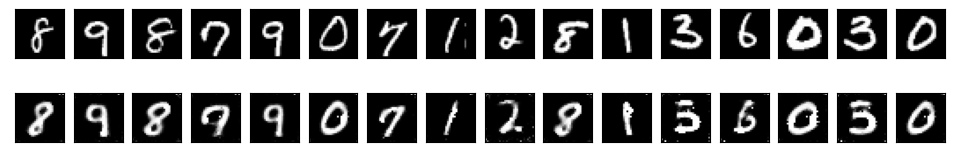

Epoch: 62/100 	 train loss: 41.8337 	 validation loss: 41.8834
Epoch: 63/100 	 train loss: 41.6675 	 validation loss: 41.9351
Epoch: 64/100 	 train loss: 41.5833 	 validation loss: 41.7391
Epoch: 65/100 	 train loss: 41.3925 	 validation loss: 41.4791
Epoch: 66/100 	 train loss: 41.1394 	 validation loss: 41.1970
Epoch: 67/100 	 train loss: 41.0280 	 validation loss: 41.3898
Epoch: 68/100 	 train loss: 40.9164 	 validation loss: 41.3095
Epoch: 69/100 	 train loss: 40.7614 	 validation loss: 41.0152
Epoch: 70/100 	 train loss: 40.6545 	 validation loss: 40.7711
Epoch: 71/100 	 train loss: 40.4516 	 validation loss: 40.7365


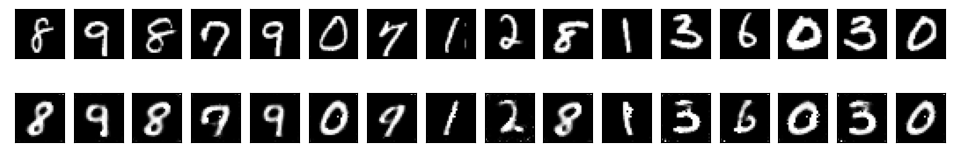

Epoch: 72/100 	 train loss: 40.2960 	 validation loss: 40.5859
Epoch: 73/100 	 train loss: 40.1025 	 validation loss: 40.1445
Epoch: 74/100 	 train loss: 39.7696 	 validation loss: 39.8882
Epoch: 75/100 	 train loss: 39.5729 	 validation loss: 39.9857
Epoch: 76/100 	 train loss: 39.4575 	 validation loss: 39.6847
Epoch: 77/100 	 train loss: 39.3141 	 validation loss: 39.5721
Epoch: 78/100 	 train loss: 39.2400 	 validation loss: 39.5171
Epoch: 79/100 	 train loss: 39.1249 	 validation loss: 39.3950
Epoch: 80/100 	 train loss: 39.0301 	 validation loss: 39.6085
Epoch: 81/100 	 train loss: 38.8591 	 validation loss: 39.3737


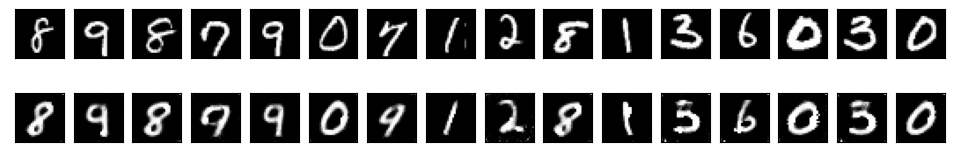

Epoch: 82/100 	 train loss: 38.7461 	 validation loss: 39.2072
Epoch: 83/100 	 train loss: 38.6483 	 validation loss: 38.9589
Epoch: 84/100 	 train loss: 38.6166 	 validation loss: 39.0863
Epoch: 85/100 	 train loss: 38.5473 	 validation loss: 39.0491
Epoch: 86/100 	 train loss: 38.4237 	 validation loss: 38.9408
Epoch: 87/100 	 train loss: 38.3109 	 validation loss: 38.6589
Epoch: 88/100 	 train loss: 38.3087 	 validation loss: 38.5667
Epoch: 89/100 	 train loss: 38.2283 	 validation loss: 38.5994
Epoch: 90/100 	 train loss: 38.0970 	 validation loss: 38.6970
Epoch: 91/100 	 train loss: 38.0729 	 validation loss: 38.8033


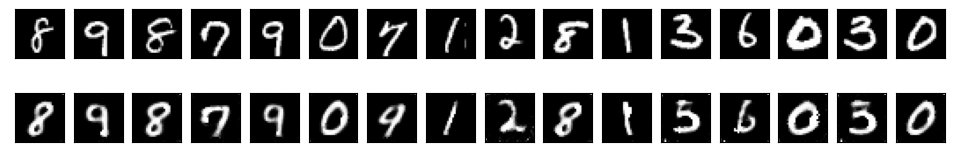

Epoch: 92/100 	 train loss: 38.0064 	 validation loss: 38.6073
Epoch: 93/100 	 train loss: 37.9824 	 validation loss: 38.4394
Epoch: 94/100 	 train loss: 37.8693 	 validation loss: 38.5043
Epoch: 95/100 	 train loss: 37.8103 	 validation loss: 38.3687
Epoch: 96/100 	 train loss: 37.7218 	 validation loss: 38.1754
Epoch: 97/100 	 train loss: 37.6377 	 validation loss: 38.2011
Epoch: 98/100 	 train loss: 37.5770 	 validation loss: 38.0910
Epoch: 99/100 	 train loss: 37.5218 	 validation loss: 38.0200
Epoch: 100/100 	 train loss: 37.4975 	 validation loss: 38.1882


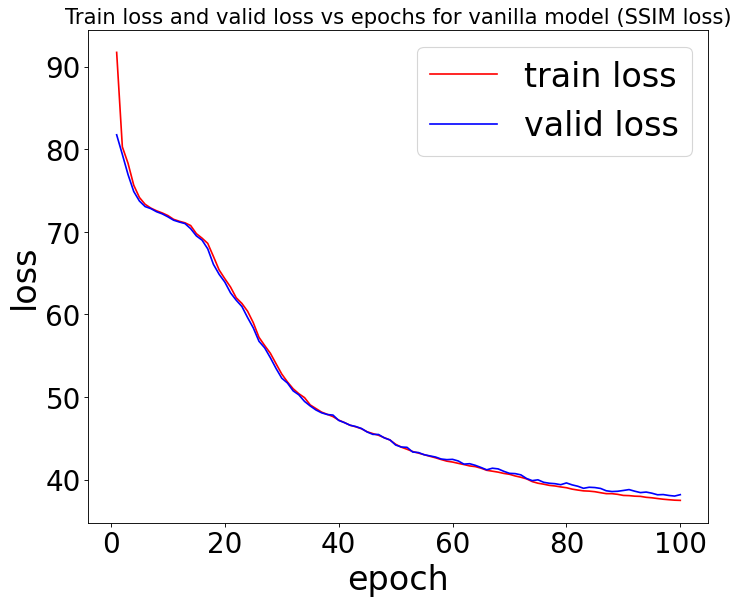

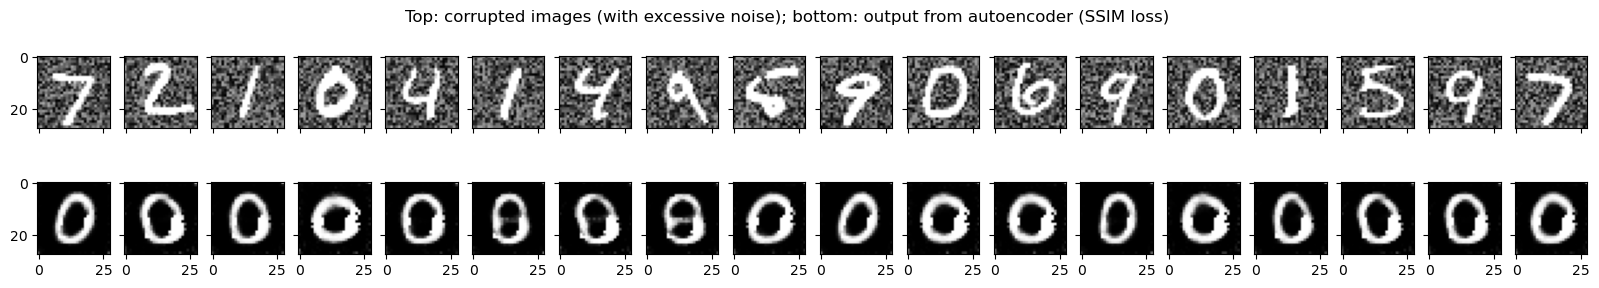

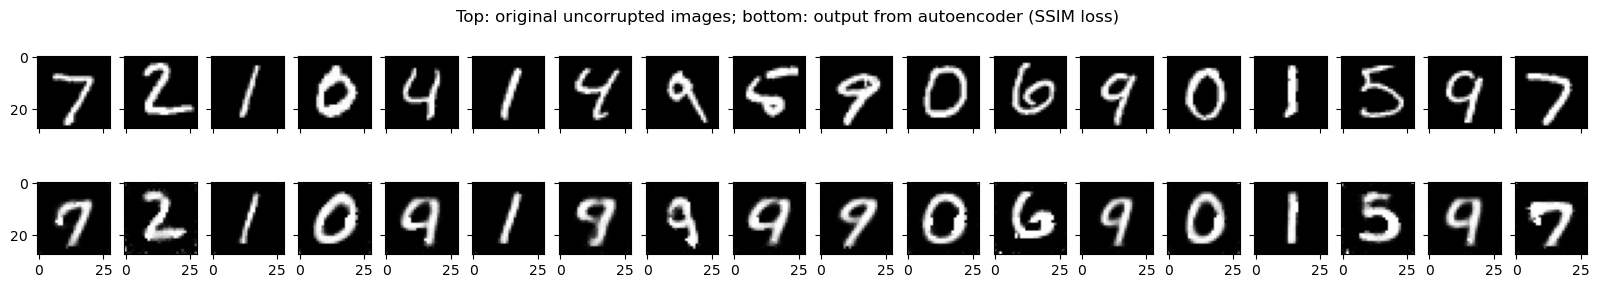

In [22]:
vanillaAEmodelSSIM = vanillaAutoEncoder().to(device=device)

trainLossesVanillaAEmodelSSIM, validLossesVanillaAEmodelSSIM = trainFC(num_epochs, vanillaAEmodelSSIM, lossFunc="SSIM", optimization="SGD", lr=0.05, momentum=momentum)
plotLossesEpochs(num_epochs, trainLossesVanillaAEmodelSSIM, validLossesVanillaAEmodelSSIM, model="vanilla", lossFunc="SSIM")
testFC(vanillaAEmodelSSIM, lossFunc="SSIM")

Epoch: 1/100 	 train loss: 4.9752 	 validation loss: 3.8041


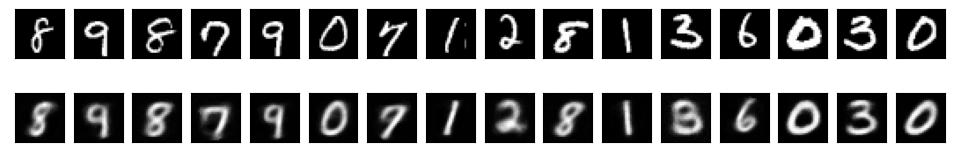

Epoch: 2/100 	 train loss: 3.9954 	 validation loss: 3.5702
Epoch: 3/100 	 train loss: 3.8582 	 validation loss: 3.4514
Epoch: 4/100 	 train loss: 3.7880 	 validation loss: 3.3918
Epoch: 5/100 	 train loss: 3.7288 	 validation loss: 3.3346
Epoch: 6/100 	 train loss: 3.6802 	 validation loss: 3.3362
Epoch: 7/100 	 train loss: 3.6582 	 validation loss: 3.3192
Epoch: 8/100 	 train loss: 3.6350 	 validation loss: 3.2714
Epoch: 9/100 	 train loss: 3.5993 	 validation loss: 3.2413
Epoch: 10/100 	 train loss: 3.5906 	 validation loss: 3.2228
Epoch: 11/100 	 train loss: 3.5659 	 validation loss: 3.2167


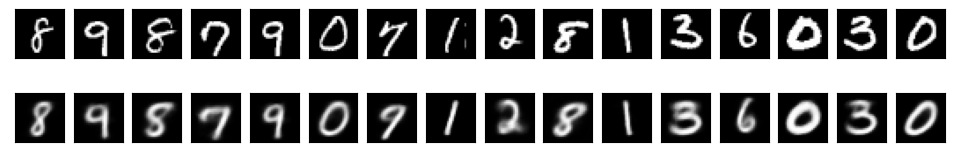

Epoch: 12/100 	 train loss: 3.5470 	 validation loss: 3.2030
Epoch: 13/100 	 train loss: 3.5341 	 validation loss: 3.1677
Epoch: 14/100 	 train loss: 3.5210 	 validation loss: 3.1626
Epoch: 15/100 	 train loss: 3.5179 	 validation loss: 3.1505
Epoch: 16/100 	 train loss: 3.5056 	 validation loss: 3.1562
Epoch: 17/100 	 train loss: 3.4832 	 validation loss: 3.1337
Epoch: 18/100 	 train loss: 3.4763 	 validation loss: 3.1418
Epoch: 19/100 	 train loss: 3.4658 	 validation loss: 3.1279
Epoch: 20/100 	 train loss: 3.4606 	 validation loss: 3.1324
Epoch: 21/100 	 train loss: 3.4428 	 validation loss: 3.1208


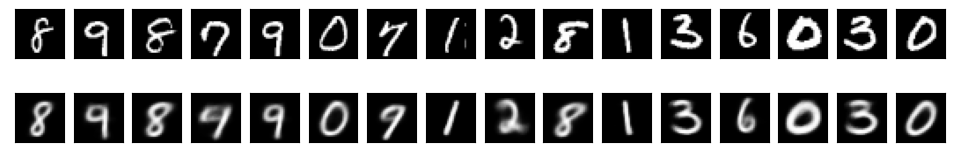

Epoch: 22/100 	 train loss: 3.4393 	 validation loss: 3.1020
Epoch: 23/100 	 train loss: 3.4226 	 validation loss: 3.1130
Epoch: 24/100 	 train loss: 3.4264 	 validation loss: 3.0872
Epoch: 25/100 	 train loss: 3.4161 	 validation loss: 3.0969
Epoch: 26/100 	 train loss: 3.4036 	 validation loss: 3.0898
Epoch: 27/100 	 train loss: 3.4069 	 validation loss: 3.0850
Epoch: 28/100 	 train loss: 3.3942 	 validation loss: 3.0918
Epoch: 29/100 	 train loss: 3.3908 	 validation loss: 3.0844
Epoch: 30/100 	 train loss: 3.3903 	 validation loss: 3.0876
Epoch: 31/100 	 train loss: 3.3752 	 validation loss: 3.0668


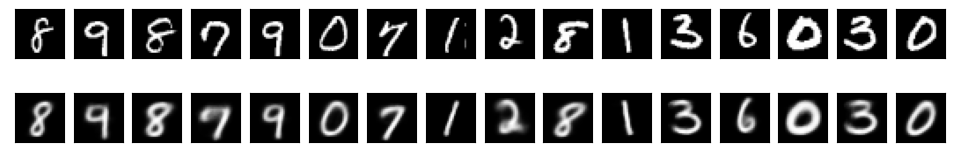

Epoch: 32/100 	 train loss: 3.3809 	 validation loss: 3.0861
Epoch: 33/100 	 train loss: 3.3658 	 validation loss: 3.0722
Epoch: 34/100 	 train loss: 3.3651 	 validation loss: 3.0617
Epoch: 35/100 	 train loss: 3.3626 	 validation loss: 3.0546
Epoch: 36/100 	 train loss: 3.3566 	 validation loss: 3.0655
Epoch: 37/100 	 train loss: 3.3440 	 validation loss: 3.0836
Epoch: 38/100 	 train loss: 3.3498 	 validation loss: 3.0711
Epoch: 39/100 	 train loss: 3.3432 	 validation loss: 3.0786
Epoch: 40/100 	 train loss: 3.3328 	 validation loss: 3.0633
Epoch: 41/100 	 train loss: 3.3310 	 validation loss: 3.0798


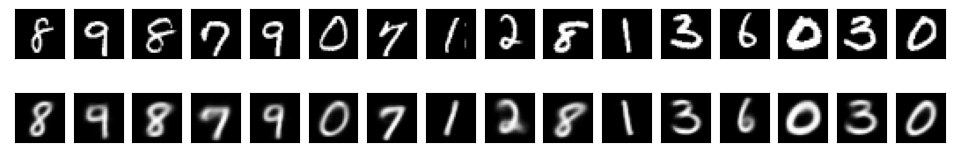

Epoch: 42/100 	 train loss: 3.3340 	 validation loss: 3.0653
Epoch: 43/100 	 train loss: 3.3235 	 validation loss: 3.0806
Epoch: 44/100 	 train loss: 3.3162 	 validation loss: 3.0481
Epoch: 45/100 	 train loss: 3.3105 	 validation loss: 3.0587
Epoch: 46/100 	 train loss: 3.3139 	 validation loss: 3.0444
Epoch: 47/100 	 train loss: 3.3066 	 validation loss: 3.0415
Epoch: 48/100 	 train loss: 3.3026 	 validation loss: 3.0471
Epoch: 49/100 	 train loss: 3.3060 	 validation loss: 3.0434
Epoch: 50/100 	 train loss: 3.3033 	 validation loss: 3.0419
Epoch: 51/100 	 train loss: 3.2955 	 validation loss: 3.0448


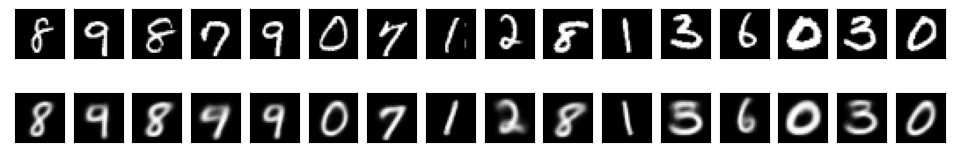

Epoch: 52/100 	 train loss: 3.2923 	 validation loss: 3.0534
Epoch: 53/100 	 train loss: 3.3009 	 validation loss: 3.0419
Epoch: 54/100 	 train loss: 3.2904 	 validation loss: 3.0579
Epoch: 55/100 	 train loss: 3.2837 	 validation loss: 3.0866
Epoch: 56/100 	 train loss: 3.2805 	 validation loss: 3.0570
Epoch: 57/100 	 train loss: 3.2801 	 validation loss: 3.0277
Epoch: 58/100 	 train loss: 3.2705 	 validation loss: 3.0639
Epoch: 59/100 	 train loss: 3.2733 	 validation loss: 3.0479
Epoch: 60/100 	 train loss: 3.2749 	 validation loss: 3.0393
Epoch: 61/100 	 train loss: 3.2693 	 validation loss: 3.0391


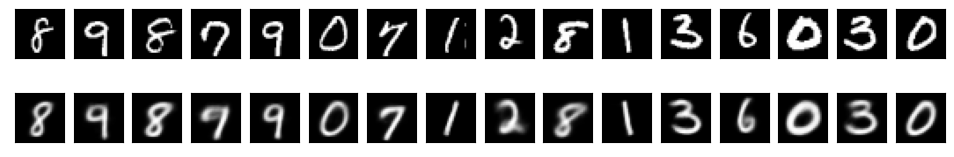

Epoch: 62/100 	 train loss: 3.2668 	 validation loss: 3.0338
Epoch: 63/100 	 train loss: 3.2670 	 validation loss: 3.0384
Epoch: 64/100 	 train loss: 3.2620 	 validation loss: 3.0523
Epoch: 65/100 	 train loss: 3.2616 	 validation loss: 3.0536
Epoch: 66/100 	 train loss: 3.2580 	 validation loss: 3.0528
Epoch: 67/100 	 train loss: 3.2520 	 validation loss: 3.0414
Epoch: 68/100 	 train loss: 3.2526 	 validation loss: 3.0380
Epoch: 69/100 	 train loss: 3.2549 	 validation loss: 3.0504
Epoch: 70/100 	 train loss: 3.2475 	 validation loss: 3.0584
Epoch: 71/100 	 train loss: 3.2419 	 validation loss: 3.0506


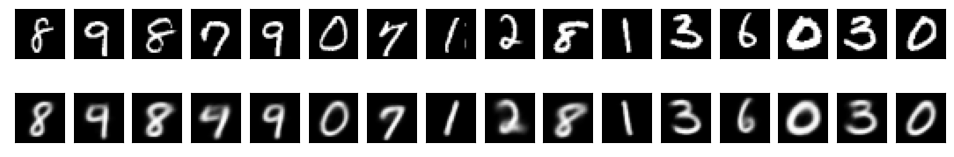

Epoch: 72/100 	 train loss: 3.2440 	 validation loss: 3.0390
Epoch: 73/100 	 train loss: 3.2458 	 validation loss: 3.0293
Epoch: 74/100 	 train loss: 3.2507 	 validation loss: 3.0162
Epoch: 75/100 	 train loss: 3.2417 	 validation loss: 3.0845
Epoch: 76/100 	 train loss: 3.2392 	 validation loss: 3.0214
Epoch: 77/100 	 train loss: 3.2361 	 validation loss: 3.0568
Epoch: 78/100 	 train loss: 3.2329 	 validation loss: 3.0325
Epoch: 79/100 	 train loss: 3.2240 	 validation loss: 3.0488
Epoch: 80/100 	 train loss: 3.2279 	 validation loss: 3.0405
Epoch: 81/100 	 train loss: 3.2361 	 validation loss: 3.0218


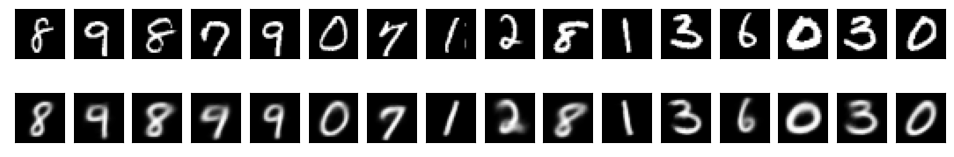

Epoch: 82/100 	 train loss: 3.2321 	 validation loss: 3.0308
Epoch: 83/100 	 train loss: 3.2280 	 validation loss: 3.0411
Epoch: 84/100 	 train loss: 3.2203 	 validation loss: 3.0336
Epoch: 85/100 	 train loss: 3.2290 	 validation loss: 3.0653
Epoch: 86/100 	 train loss: 3.2232 	 validation loss: 3.0472
Epoch: 87/100 	 train loss: 3.2234 	 validation loss: 3.0480
Epoch: 88/100 	 train loss: 3.2207 	 validation loss: 3.0359
Epoch: 89/100 	 train loss: 3.2124 	 validation loss: 3.0299
Epoch: 90/100 	 train loss: 3.2145 	 validation loss: 3.0265
Epoch: 91/100 	 train loss: 3.2134 	 validation loss: 3.0546


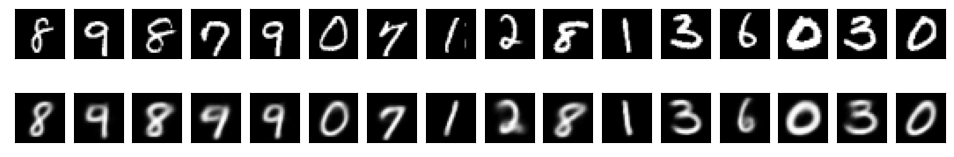

Epoch: 92/100 	 train loss: 3.2133 	 validation loss: 3.0332
Epoch: 93/100 	 train loss: 3.2145 	 validation loss: 3.0419
Epoch: 94/100 	 train loss: 3.2102 	 validation loss: 3.0208
Epoch: 95/100 	 train loss: 3.2076 	 validation loss: 3.0521
Epoch: 96/100 	 train loss: 3.2054 	 validation loss: 3.0386
Epoch: 97/100 	 train loss: 3.2045 	 validation loss: 3.0206
Epoch: 98/100 	 train loss: 3.2067 	 validation loss: 3.0415
Epoch: 99/100 	 train loss: 3.2042 	 validation loss: 3.0629
Epoch: 100/100 	 train loss: 3.2060 	 validation loss: 3.0253


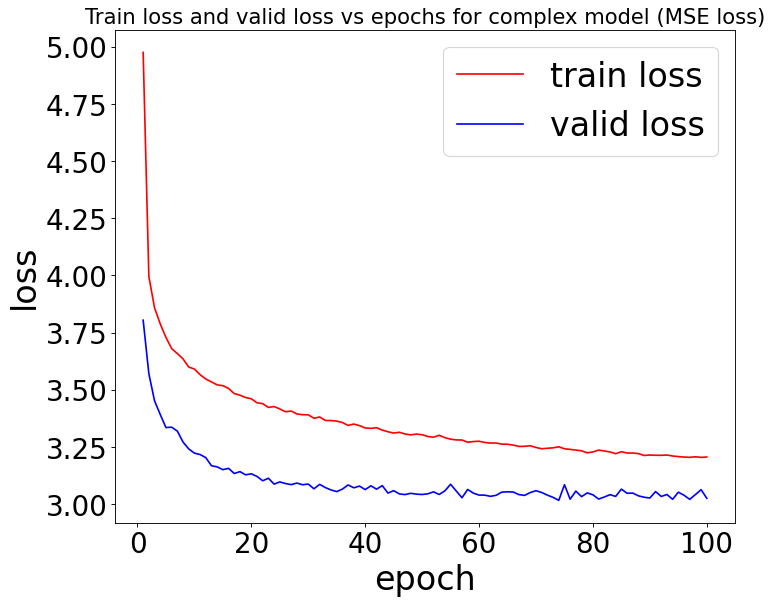

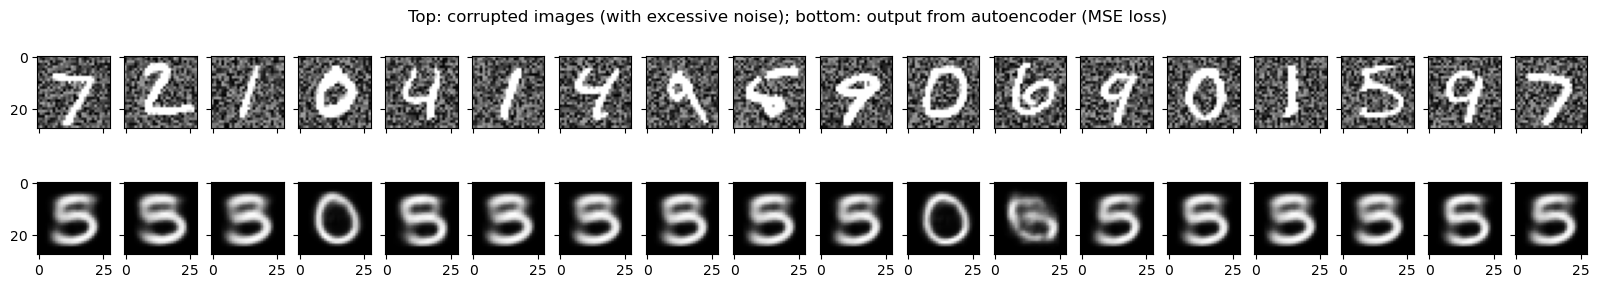

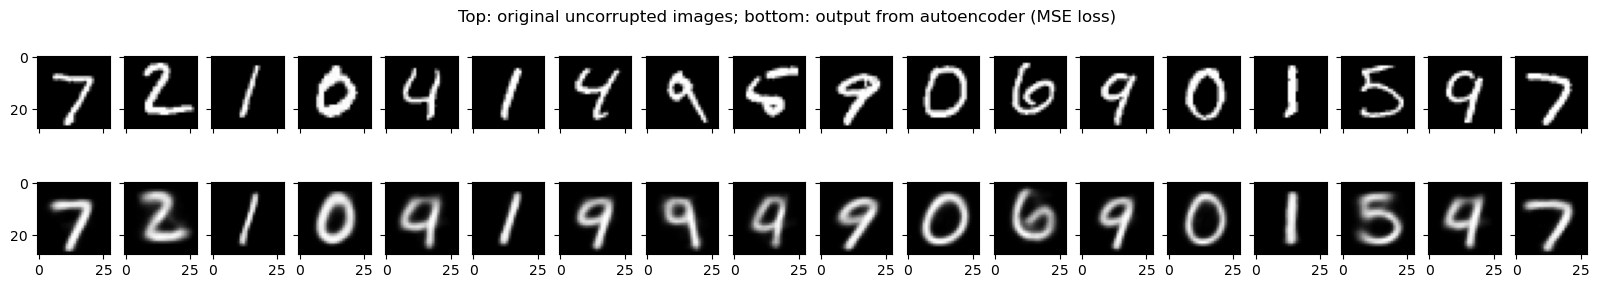

In [23]:
trainLossesComplexAEmodel, validLossesComplexAEmodel = trainFC(num_epochs, complexAEmodel, lossFunc="MSE", optimization="Adam", lr=learning_rate, momentum=momentum)
plotLossesEpochs(num_epochs, trainLossesComplexAEmodel, validLossesComplexAEmodel, model="complex", lossFunc="MSE")
testFC(complexAEmodel, lossFunc="MSE")

Epoch: 1/100 	Training Loss: 7.4127 	Validation Loss: 0.4152


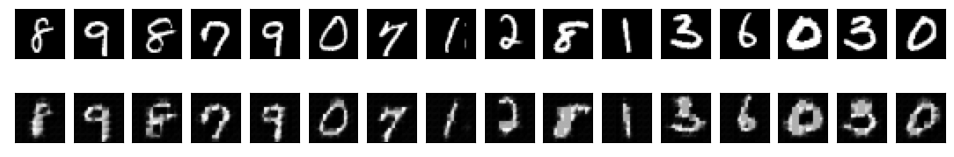

Epoch: 2/100 	Training Loss: 2.0470 	Validation Loss: 0.3319
Epoch: 3/100 	Training Loss: 1.7979 	Validation Loss: 0.3025
Epoch: 4/100 	Training Loss: 1.6530 	Validation Loss: 0.2810
Epoch: 5/100 	Training Loss: 1.5514 	Validation Loss: 0.2661
Epoch: 6/100 	Training Loss: 1.4783 	Validation Loss: 0.2551
Epoch: 7/100 	Training Loss: 1.4232 	Validation Loss: 0.2465
Epoch: 8/100 	Training Loss: 1.3804 	Validation Loss: 0.2401
Epoch: 9/100 	Training Loss: 1.3474 	Validation Loss: 0.2348
Epoch: 10/100 	Training Loss: 1.3226 	Validation Loss: 0.2309


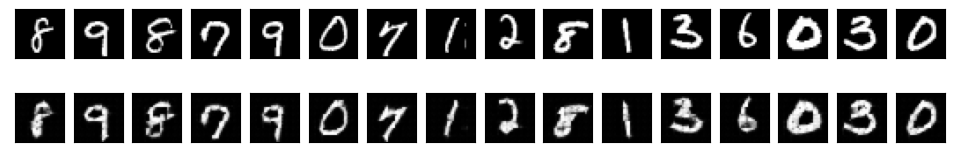

Epoch: 11/100 	Training Loss: 1.3022 	Validation Loss: 0.2278
Epoch: 12/100 	Training Loss: 1.2848 	Validation Loss: 0.2246
Epoch: 13/100 	Training Loss: 1.2692 	Validation Loss: 0.2218
Epoch: 14/100 	Training Loss: 1.2552 	Validation Loss: 0.2196
Epoch: 15/100 	Training Loss: 1.2420 	Validation Loss: 0.2174
Epoch: 16/100 	Training Loss: 1.2284 	Validation Loss: 0.2150
Epoch: 17/100 	Training Loss: 1.2177 	Validation Loss: 0.2133
Epoch: 18/100 	Training Loss: 1.2082 	Validation Loss: 0.2116
Epoch: 19/100 	Training Loss: 1.1994 	Validation Loss: 0.2100
Epoch: 20/100 	Training Loss: 1.1905 	Validation Loss: 0.2089


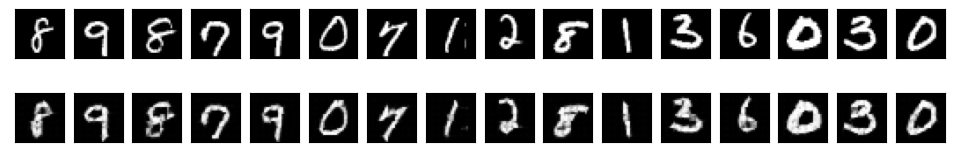

Epoch: 21/100 	Training Loss: 1.1831 	Validation Loss: 0.2080
Epoch: 22/100 	Training Loss: 1.1754 	Validation Loss: 0.2062
Epoch: 23/100 	Training Loss: 1.1688 	Validation Loss: 0.2052
Epoch: 24/100 	Training Loss: 1.1622 	Validation Loss: 0.2041
Epoch: 25/100 	Training Loss: 1.1566 	Validation Loss: 0.2030
Epoch: 26/100 	Training Loss: 1.1510 	Validation Loss: 0.2024
Epoch: 27/100 	Training Loss: 1.1466 	Validation Loss: 0.2022
Epoch: 28/100 	Training Loss: 1.1418 	Validation Loss: 0.2005
Epoch: 29/100 	Training Loss: 1.1379 	Validation Loss: 0.1998
Epoch: 30/100 	Training Loss: 1.1345 	Validation Loss: 0.1994


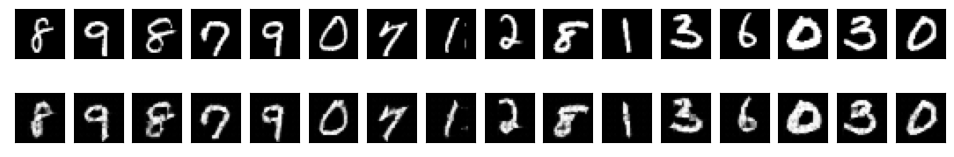

Epoch: 31/100 	Training Loss: 1.1311 	Validation Loss: 0.1988
Epoch: 32/100 	Training Loss: 1.1278 	Validation Loss: 0.1981
Epoch: 33/100 	Training Loss: 1.1250 	Validation Loss: 0.1979
Epoch: 34/100 	Training Loss: 1.1224 	Validation Loss: 0.1976
Epoch: 35/100 	Training Loss: 1.1199 	Validation Loss: 0.1967
Epoch: 36/100 	Training Loss: 1.1175 	Validation Loss: 0.1965
Epoch: 37/100 	Training Loss: 1.1160 	Validation Loss: 0.1964
Epoch: 38/100 	Training Loss: 1.1136 	Validation Loss: 0.1957
Epoch: 39/100 	Training Loss: 1.1115 	Validation Loss: 0.1959
Epoch: 40/100 	Training Loss: 1.1103 	Validation Loss: 0.1953


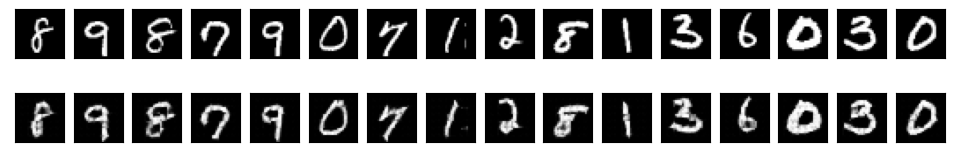

Epoch: 41/100 	Training Loss: 1.1079 	Validation Loss: 0.1951
Epoch: 42/100 	Training Loss: 1.1065 	Validation Loss: 0.1945
Epoch: 43/100 	Training Loss: 1.1048 	Validation Loss: 0.1944
Epoch: 44/100 	Training Loss: 1.1030 	Validation Loss: 0.1942
Epoch: 45/100 	Training Loss: 1.1015 	Validation Loss: 0.1940
Epoch: 46/100 	Training Loss: 1.1000 	Validation Loss: 0.1933
Epoch: 47/100 	Training Loss: 1.0977 	Validation Loss: 0.1929
Epoch: 48/100 	Training Loss: 1.0965 	Validation Loss: 0.1929
Epoch: 49/100 	Training Loss: 1.0947 	Validation Loss: 0.1924
Epoch: 50/100 	Training Loss: 1.0934 	Validation Loss: 0.1927


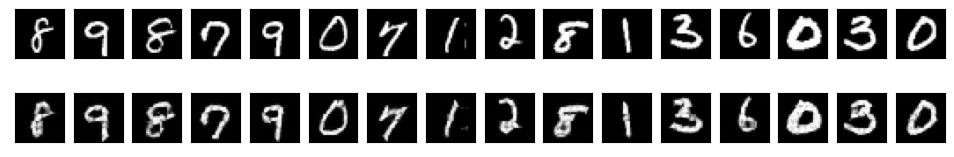

Epoch: 51/100 	Training Loss: 1.0920 	Validation Loss: 0.1923
Epoch: 52/100 	Training Loss: 1.0907 	Validation Loss: 0.1917
Epoch: 53/100 	Training Loss: 1.0896 	Validation Loss: 0.1916
Epoch: 54/100 	Training Loss: 1.0885 	Validation Loss: 0.1916
Epoch: 55/100 	Training Loss: 1.0869 	Validation Loss: 0.1914
Epoch: 56/100 	Training Loss: 1.0861 	Validation Loss: 0.1924
Epoch: 57/100 	Training Loss: 1.0851 	Validation Loss: 0.1910
Epoch: 58/100 	Training Loss: 1.0841 	Validation Loss: 0.1913
Epoch: 59/100 	Training Loss: 1.0833 	Validation Loss: 0.1908
Epoch: 60/100 	Training Loss: 1.0824 	Validation Loss: 0.1910


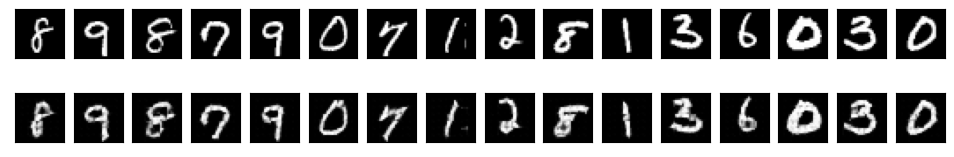

Epoch: 61/100 	Training Loss: 1.0812 	Validation Loss: 0.1901
Epoch: 62/100 	Training Loss: 1.0802 	Validation Loss: 0.1898
Epoch: 63/100 	Training Loss: 1.0792 	Validation Loss: 0.1897
Epoch: 64/100 	Training Loss: 1.0784 	Validation Loss: 0.1896
Epoch: 65/100 	Training Loss: 1.0776 	Validation Loss: 0.1896
Epoch: 66/100 	Training Loss: 1.0767 	Validation Loss: 0.1894
Epoch: 67/100 	Training Loss: 1.0756 	Validation Loss: 0.1900
Epoch: 68/100 	Training Loss: 1.0756 	Validation Loss: 0.1891
Epoch: 69/100 	Training Loss: 1.0746 	Validation Loss: 0.1890
Epoch: 70/100 	Training Loss: 1.0738 	Validation Loss: 0.1890


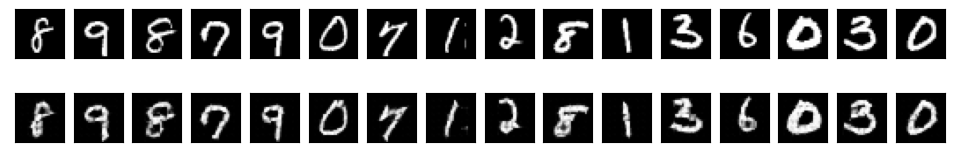

Epoch: 71/100 	Training Loss: 1.0735 	Validation Loss: 0.1888
Epoch: 72/100 	Training Loss: 1.0730 	Validation Loss: 0.1887
Epoch: 73/100 	Training Loss: 1.0720 	Validation Loss: 0.1886
Epoch: 74/100 	Training Loss: 1.0712 	Validation Loss: 0.1890
Epoch: 75/100 	Training Loss: 1.0712 	Validation Loss: 0.1887
Epoch: 76/100 	Training Loss: 1.0702 	Validation Loss: 0.1882
Epoch: 77/100 	Training Loss: 1.0699 	Validation Loss: 0.1884
Epoch: 78/100 	Training Loss: 1.0692 	Validation Loss: 0.1884
Epoch: 79/100 	Training Loss: 1.0687 	Validation Loss: 0.1882
Epoch: 80/100 	Training Loss: 1.0684 	Validation Loss: 0.1881


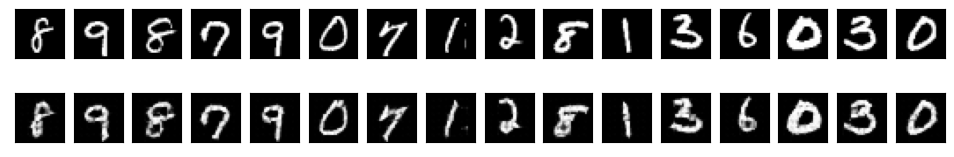

Epoch: 81/100 	Training Loss: 1.0679 	Validation Loss: 0.1883
Epoch: 82/100 	Training Loss: 1.0673 	Validation Loss: 0.1883
Epoch: 83/100 	Training Loss: 1.0667 	Validation Loss: 0.1876
Epoch: 84/100 	Training Loss: 1.0666 	Validation Loss: 0.1880
Epoch: 85/100 	Training Loss: 1.0660 	Validation Loss: 0.1884
Epoch: 86/100 	Training Loss: 1.0650 	Validation Loss: 0.1874
Epoch: 87/100 	Training Loss: 1.0645 	Validation Loss: 0.1874
Epoch: 88/100 	Training Loss: 1.0634 	Validation Loss: 0.1872
Epoch: 89/100 	Training Loss: 1.0627 	Validation Loss: 0.1873
Epoch: 90/100 	Training Loss: 1.0627 	Validation Loss: 0.1873


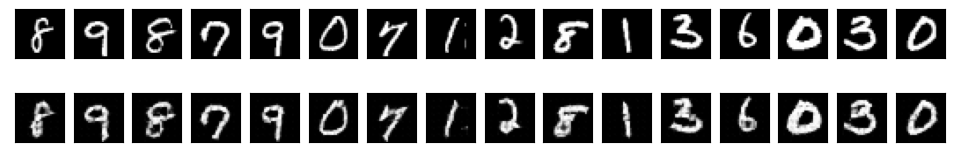

Epoch: 91/100 	Training Loss: 1.0621 	Validation Loss: 0.1872
Epoch: 92/100 	Training Loss: 1.0618 	Validation Loss: 0.1872
Epoch: 93/100 	Training Loss: 1.0610 	Validation Loss: 0.1873
Epoch: 94/100 	Training Loss: 1.0609 	Validation Loss: 0.1865
Epoch: 95/100 	Training Loss: 1.0600 	Validation Loss: 0.1865
Epoch: 96/100 	Training Loss: 1.0601 	Validation Loss: 0.1868
Epoch: 97/100 	Training Loss: 1.0592 	Validation Loss: 0.1865
Epoch: 98/100 	Training Loss: 1.0590 	Validation Loss: 0.1866
Epoch: 99/100 	Training Loss: 1.0589 	Validation Loss: 0.1860
Epoch: 100/100 	Training Loss: 1.0584 	Validation Loss: 0.1864


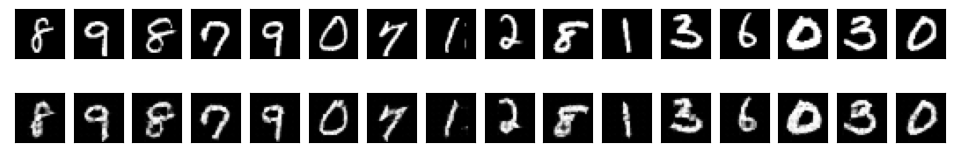

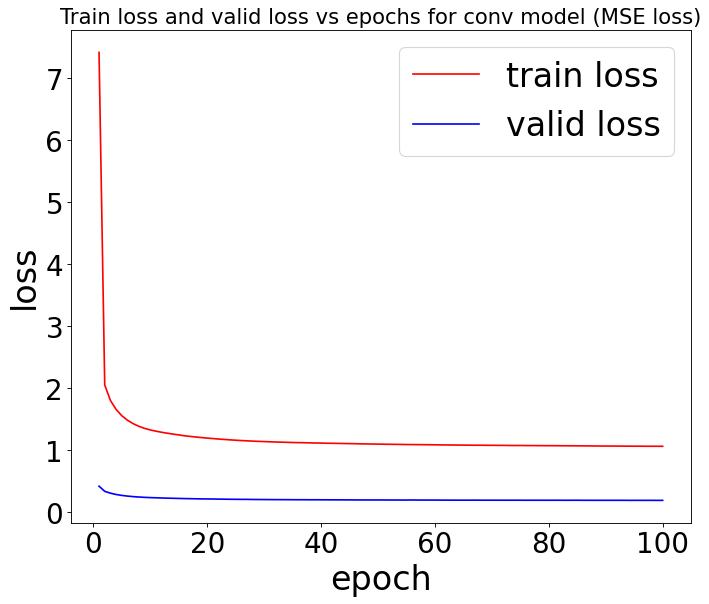

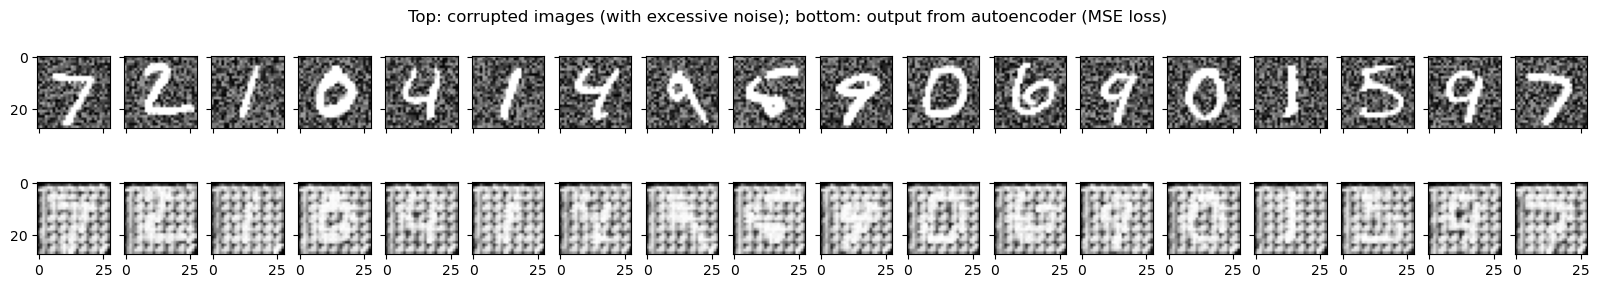

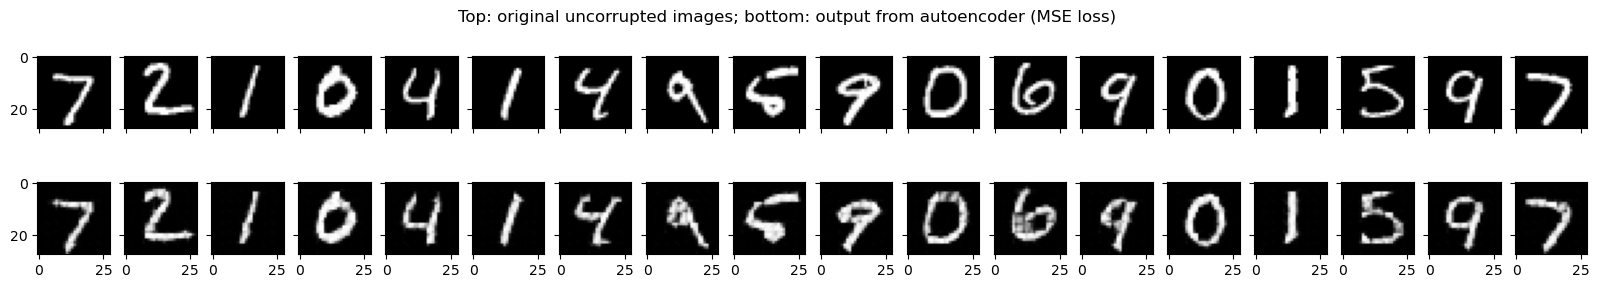

In [24]:
trainLossesConvAEmodel, validLossesConvAEmodel = trainConv(num_epochs, convAEmodel, lossFunc="MSE", optimization="Adam", lr=learning_rate, momentum=momentum)
plotLossesEpochs(num_epochs, trainLossesConvAEmodel, validLossesConvAEmodel, model="conv", lossFunc="MSE")
testConv(convAEmodel, lossFunc="MSE")

# Threshold value #

## plot the loss distribution for the normal and anomalous images ##

(10000, 784)
10000


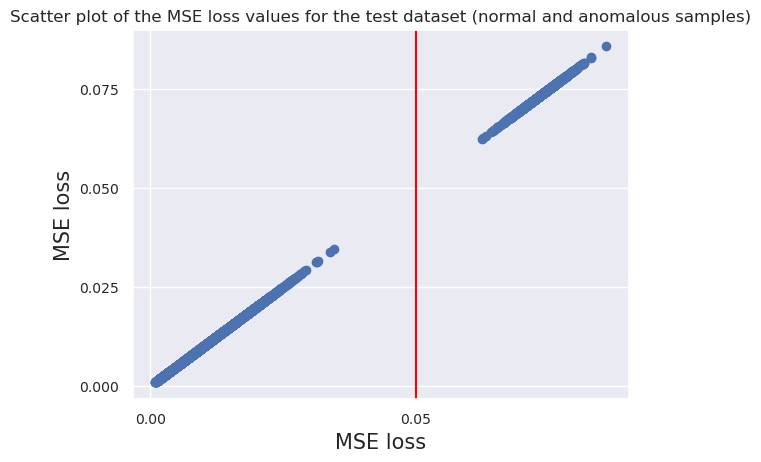

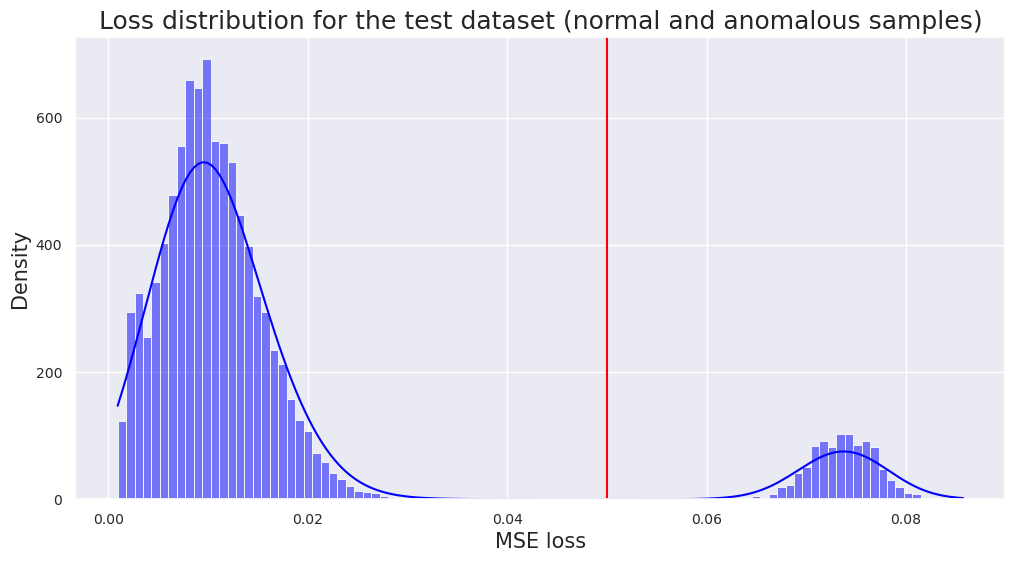

In [35]:
#lossfunc = nn.MSELoss()
lossfunc = MSE()

# load checkpoint to evaluate the convolutional autoencoder model
checkpoint = torch.load("checkpoint_convAutoencoder_MSEloss.pt")
convAEmodel.load_state_dict(checkpoint['model_state_dict'])

convAEmodel.eval()

loss_distribution = []
test_anomalous = pd.read_csv('test_anomaly_.csv', index_col=[0])
print(test_anomalous.shape)
for i in range(len(test_anomalous)):
    sample = torch.from_numpy(np.array(test_anomalous.iloc[i][0:])/255).float()
    input_ = sample.view(-1,28,28).to(device=device)
    output = convAEmodel(input_)
    loss = lossfunc(input_, output)
    loss_distribution.append(loss.item())

print(len(loss_distribution))

################
# scatter plot #
################

threshold = 0.05

loss_scatter = []
for i, loss_value in enumerate(loss_distribution):
    loss_scatter.append((loss_value, loss_value))
    
plt.scatter(*zip(*loss_scatter))

plt.title("Scatter plot of the MSE loss values for the test dataset (normal and anomalous samples)", fontsize=12)
plt.xlabel("MSE loss", fontsize=15)
plt.ylabel("MSE loss", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(threshold, 0.0, 1.0, color='red')

##########################
# loss distribution plot #
##########################
plt.figure(figsize=(12,6))
plt.title("Loss distribution for the test dataset (normal and anomalous samples)", fontsize=18)
plt.xlabel("MSE loss", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#sns.distplot(loss_distribution, bins=100, kde=True, color='blue')
sns.histplot(loss_distribution, bins=100, kde=True, color='blue')
plt.axvline(threshold, 0.0, 1.0, color='red')
plt.savefig('loss_distribution.pdf')

## Confusion matrix ##

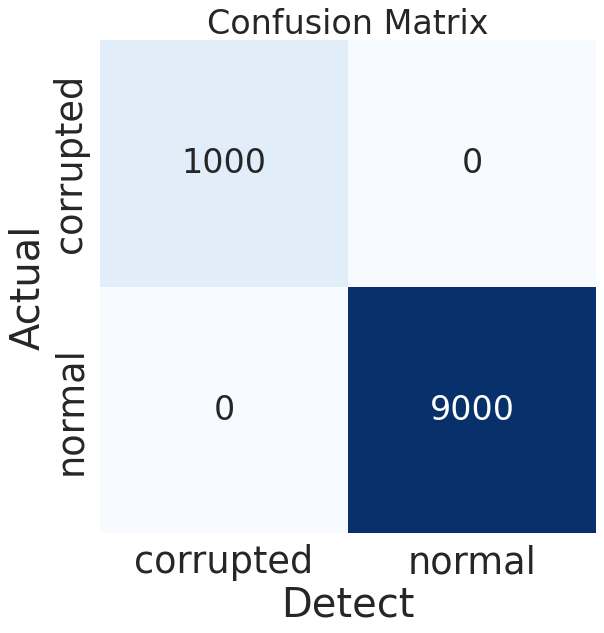

In [36]:
df_anomalous = pd.read_csv('test_anomaly_.csv')
df_confM = pd.DataFrame(df_anomalous['label'])
df_confM.rename(columns={'label': 'actual'}, inplace=True)
df_confM.insert(1, "detect", np.zeros(len(loss_distribution), dtype=int))

TP = 0
FP = 0
TN = 0
FN = 0
total_anomalous = 0

output_normal = []
output_anomaly = []

# 1: anomalous sample / corrupted sample
# 0: normal sample
for i in range(len(loss_distribution)):
    if loss_distribution[i] >= threshold:
        df_confM.loc[i]['detect'] = 1
        output_anomaly.append(loss_distribution[i])
    else:
        output_normal.append(loss_distribution[i])

for i in range(len(loss_distribution)):
    if df_confM.loc[i]['actual']==1 and df_confM.loc[i]['detect']==1:
        TP += 1
    elif df_confM.loc[i]['actual']==0 and df_confM.loc[i]['detect']==0:
        TN += 1
    elif df_confM.loc[i]['actual']==1 and df_confM.loc[i]['detect']==0:
        FN += 1
    elif df_confM.loc[i]['actual']==0 and df_confM.loc[i]['detect']==1:
        FP += 1
        
figure(figsize=(8, 8), dpi=80)
confMat = [[TP, FN],[FP, TN]]
x_axis_labels = ['corrupted', 'normal']
y_axis_labels = ['corrupted', 'normal']
plt.title("Confusion Matrix", fontsize=30)
confusionMatrix = sns.heatmap(confMat, annot=True, annot_kws={"size":30}, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False, cmap="Blues")
confusionMatrix.set(xlabel='Detect', ylabel='Actual')
sns.set_theme(font_scale=3.0)
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

# ROC and Precision-Recall Curves #

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [28]:
def roc_pr_curves(neg, pos):
    '''
    Plot the Receiver Operating Characteristic (ROC) and Precision-Recall Curves
    
    Parameters:
        neg: negative input
        pos: postive input
    
    Return:
        None
    '''
    # translate to scores from 0 to 1
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(len(neg))
    y_true_pos = np.ones(len(pos))
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 3  # line width
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    #plt.show()
    plt.savefig('ROC.pdf', bbox_inches='tight')
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title("Precision-Recall Curve", fontsize=15)
    plt.legend(loc="center", fontsize=15)
    #plt.show()
    plt.savefig('PRC.pdf', bbox_inches='tight')

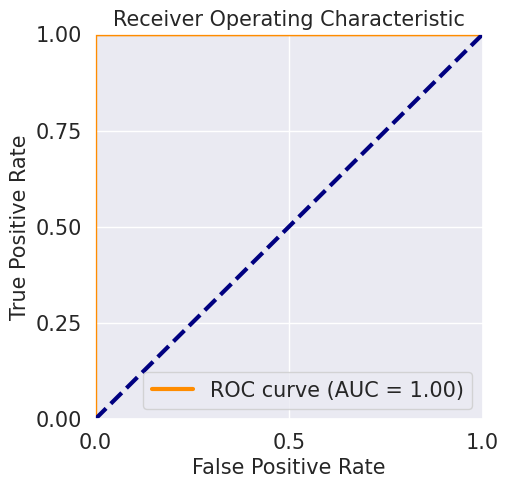

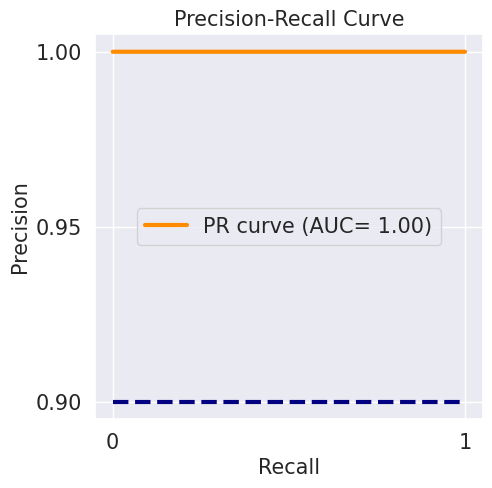

In [29]:
roc_pr_curves(output_anomaly, output_normal)